In [76]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

Bring in the separate csvs and concat into a single file

In [2]:
df = pd.read_csv('../../data/intermediate/data_concat.csv')

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/396735133.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data/intermediate/data_concat.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949511 entries, 0 to 949510
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                949511 non-null  object 
 1   town                 949511 non-null  object 
 2   flat_type            949511 non-null  object 
 3   block                949511 non-null  object 
 4   street_name          949511 non-null  object 
 5   storey_range         949511 non-null  object 
 6   floor_area_sqm       949511 non-null  float64
 7   flat_model           949511 non-null  object 
 8   lease_commence_date  949511 non-null  int64  
 9   resale_price         949511 non-null  float64
 10  remaining_lease      240461 non-null  object 
 11  year                 949511 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 86.9+ MB


In [4]:
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,year
count,949511.000000,949511.000000,9.495110e+05,949511.000000
mean,95.677121,1988.508689,3.280508e+05,2006.594936
std,25.783714,10.896028,1.773675e+05,9.611320
min,28.000000,1966.000000,5.000000e+03,1990.000000
25%,73.000000,1981.000000,1.958000e+05,1999.000000
50%,93.000000,1986.000000,3.020000e+05,2005.000000
75%,113.000000,1996.000000,4.250000e+05,2015.000000
max,366.700000,2021.000000,1.600000e+06,2025.000000


In [5]:
df.isnull().sum().sort_values(ascending=False)

remaining_lease        709050
month                       0
town                        0
flat_type                   0
block                       0
street_name                 0
storey_range                0
floor_area_sqm              0
flat_model                  0
lease_commence_date         0
resale_price                0
year                        0
dtype: int64

In [6]:
df = df.drop_duplicates()
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN,1990
1,1990-01-01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,NaN,1990
2,1990-01-01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,NaN,1990
3,1990-01-01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,NaN,1990
4,1990-01-01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,NaN,1990
...,...,...,...,...,...,...,...,...,...,...,...,...
949506,2025-03-01,TAMPINES,4 ROOM,613A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,795000.0,94 years 08 months,2025
949507,2025-03-01,TAMPINES,4 ROOM,608A,TAMPINES NTH DR 1,04 TO 06,93.0,Model A,2020,715000.0,94 years 08 months,2025
949508,2025-03-01,TAMPINES,4 ROOM,609A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,790000.0,94 years 08 months,2025
949509,2025-03-01,TAMPINES,4 ROOM,113,TAMPINES ST 11,04 TO 06,115.0,Model A,1982,700000.0,56 years 05 months,2025


There were 1909 duplicates.

Since majority does not have remaining_lease, and that this can be derived (lease_commence_date + 99 - month) will drop this column first.

In [7]:
df = df.drop(columns=['remaining_lease'])
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year
0,1990-01-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,1990
1,1990-01-01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,1990
2,1990-01-01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,1990
3,1990-01-01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,1990
4,1990-01-01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,1990
...,...,...,...,...,...,...,...,...,...,...,...
949506,2025-03-01,TAMPINES,4 ROOM,613A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,795000.0,2025
949507,2025-03-01,TAMPINES,4 ROOM,608A,TAMPINES NTH DR 1,04 TO 06,93.0,Model A,2020,715000.0,2025
949508,2025-03-01,TAMPINES,4 ROOM,609A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,790000.0,2025
949509,2025-03-01,TAMPINES,4 ROOM,113,TAMPINES ST 11,04 TO 06,115.0,Model A,1982,700000.0,2025


In [8]:
df["year"] = df["month"].str[:4]
df["month"] = df["month"].str[5:7]
df["day"] = df["month"].str[-2:]
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,day
0,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,1990,01
1,01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,1990,01
2,01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,1990,01
3,01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,1990,01
4,01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,1990,01
...,...,...,...,...,...,...,...,...,...,...,...,...
949506,03,TAMPINES,4 ROOM,613A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,795000.0,2025,03
949507,03,TAMPINES,4 ROOM,608A,TAMPINES NTH DR 1,04 TO 06,93.0,Model A,2020,715000.0,2025,03
949508,03,TAMPINES,4 ROOM,609A,TAMPINES NTH DR 1,10 TO 12,93.0,Model A,2020,790000.0,2025,03
949509,03,TAMPINES,4 ROOM,113,TAMPINES ST 11,04 TO 06,115.0,Model A,1982,700000.0,2025,03


In [9]:
df['flat_type'] = df['flat_type'].replace('MULTI GENERATION', 'MULTI-GENERATION')
df['flat_type'].value_counts()

flat_type
4 ROOM              361382
3 ROOM              300562
5 ROOM              200379
EXECUTIVE            71001
2 ROOM               12452
1 ROOM                1281
MULTI-GENERATION       545
Name: count, dtype: int64

In [10]:
df['flat_model'] = df['flat_model'].str.upper()
df['flat_model'] = df['flat_model'].replace('MULTI GENERATION', 'MULTI-GENERATION')
df['flat_model'].value_counts()

flat_model
MODEL A                   273428
IMPROVED                  246514
NEW GENERATION            191164
SIMPLIFIED                 58281
PREMIUM APARTMENT          48966
STANDARD                   42990
APARTMENT                  36165
MAISONETTE                 30171
MODEL A2                   10365
DBSS                        3577
MODEL A-MAISONETTE          2116
ADJOINED FLAT               1278
TERRACE                      703
MULTI-GENERATION             545
TYPE S1                      468
2-ROOM                       260
TYPE S2                      229
IMPROVED-MAISONETTE          128
PREMIUM APARTMENT LOFT       115
PREMIUM MAISONETTE            88
3GEN                          51
Name: count, dtype: int64

In [11]:
df['town'].value_counts()

town
TAMPINES           81484
YISHUN             71389
JURONG WEST        68036
BEDOK              67533
WOODLANDS          67006
ANG MO KIO         52828
HOUGANG            51772
BUKIT BATOK        45671
CHOA CHU KANG      39265
BUKIT MERAH        35134
SENGKANG           34178
PASIR RIS          33684
TOA PAYOH          32171
QUEENSTOWN         29279
GEYLANG            28698
CLEMENTI           28426
BUKIT PANJANG      28354
KALLANG/WHAMPOA    27878
JURONG EAST        25174
SERANGOON          23147
PUNGGOL            22125
BISHAN             21548
SEMBAWANG          14760
MARINE PARADE       8149
CENTRAL AREA        7284
BUKIT TIMAH         2566
LIM CHU KANG          63
Name: count, dtype: int64

In [12]:
# mapping towns to regions for a larger picture look

town_to_region = {
    "TAMPINES": "East",
    "YISHUN": "North",
    "JURONG WEST": "West",
    "BEDOK": "East",
    "WOODLANDS": "North",
    "ANG MO KIO": "North-East",
    "HOUGANG": "North-East",
    "BUKIT BATOK": "West",
    "CHOA CHU KANG": "West",
    "BUKIT MERAH": "Central",
    "SENGKANG": "North-East",
    "PASIR RIS": "East",
    "TOA PAYOH": "Central",
    "QUEENSTOWN": "Central",
    "GEYLANG": "Central",
    "CLEMENTI": "West",
    "BUKIT PANJANG": "West",
    "KALLANG/WHAMPOA": "Central",
    "JURONG EAST": "West",
    "SERANGOON": "North-East",
    "PUNGGOL": "North-East",
    "BISHAN": "Central",
    "SEMBAWANG": "North",
    "MARINE PARADE": "East",
    "CENTRAL AREA": "Central",
    "BUKIT TIMAH": "Central",
    "LIM CHU KANG": "West"
}

df["region"] = df["town"].map(town_to_region)

In [13]:
df['storey_range'].value_counts()

storey_range
04 TO 06    237176
07 TO 09    214359
01 TO 03    190155
10 TO 12    182581
13 TO 15     64135
16 TO 18     25094
19 TO 21     11839
22 TO 24      7701
25 TO 27      3646
01 TO 05      2696
06 TO 10      2472
28 TO 30      1772
11 TO 15      1259
31 TO 33       707
34 TO 36       645
37 TO 39       550
40 TO 42       266
16 TO 20       265
21 TO 25        92
43 TO 45        71
46 TO 48        53
26 TO 30        39
49 TO 51        20
36 TO 40         7
31 TO 35         2
Name: count, dtype: int64

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/3376952713.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_prices_region, x="region", y="resale_price", palette="viridis")


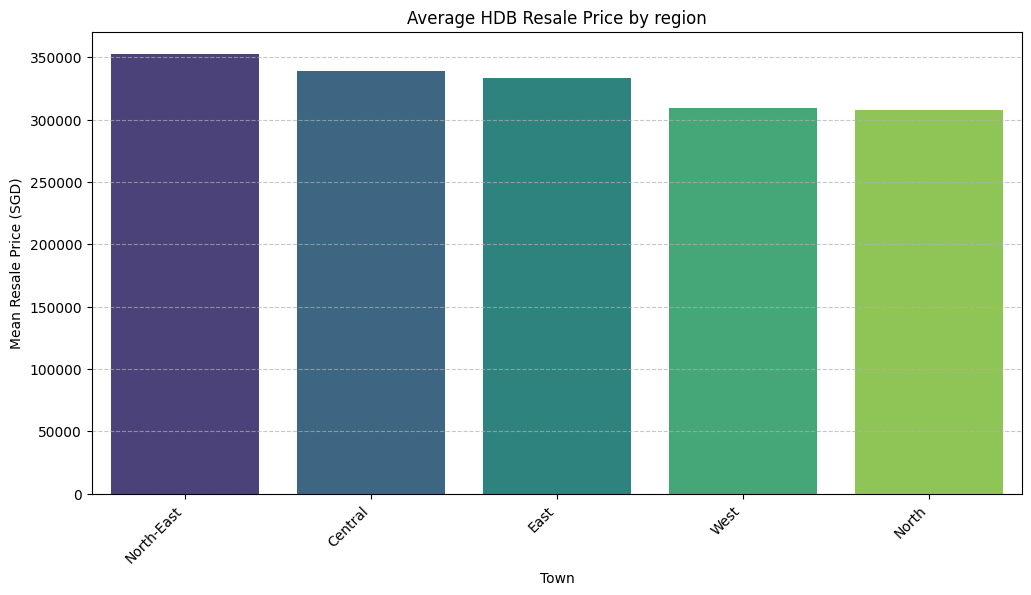

In [14]:
mean_prices_region = df.groupby("region")["resale_price"].mean().reset_index()

mean_prices_region = mean_prices_region.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_prices_region, x="region", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average HDB Resale Price by region")
plt.xlabel("Town")
plt.ylabel("Mean Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/1162570209.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_prices_region, x="region", y="resale_price", palette="viridis")


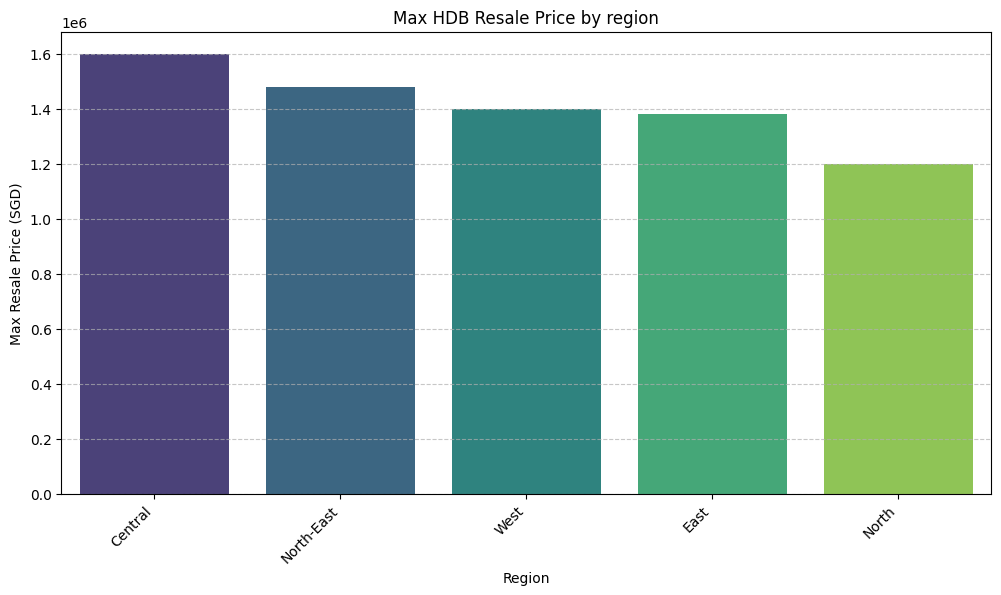

In [15]:
max_prices_region = df.groupby("region")["resale_price"].max().reset_index()

max_prices_region = max_prices_region.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_prices_region, x="region", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max HDB Resale Price by region")
plt.xlabel("Region")
plt.ylabel("Max Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/2027457744.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_price_models, x="flat_model", y="resale_price", palette="viridis")


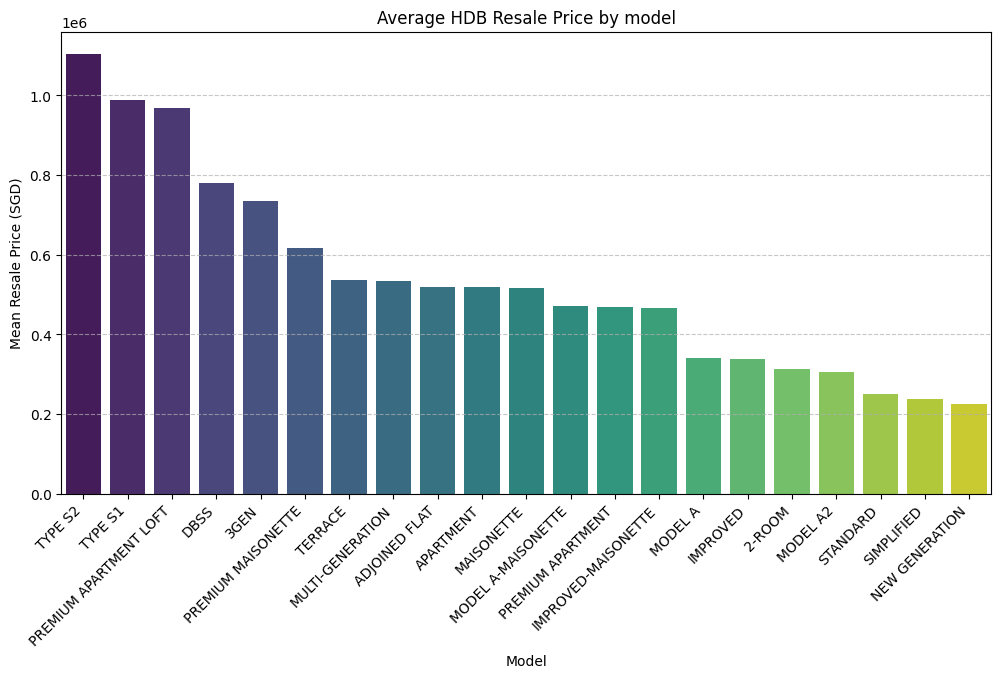

In [16]:
mean_price_models = df.groupby("flat_model")["resale_price"].mean().reset_index()

mean_price_models = mean_price_models.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_price_models, x="flat_model", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average HDB Resale Price by model")
plt.xlabel("Model")
plt.ylabel("Mean Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/1684638120.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_price_models, x="flat_model", y="resale_price", palette="viridis")


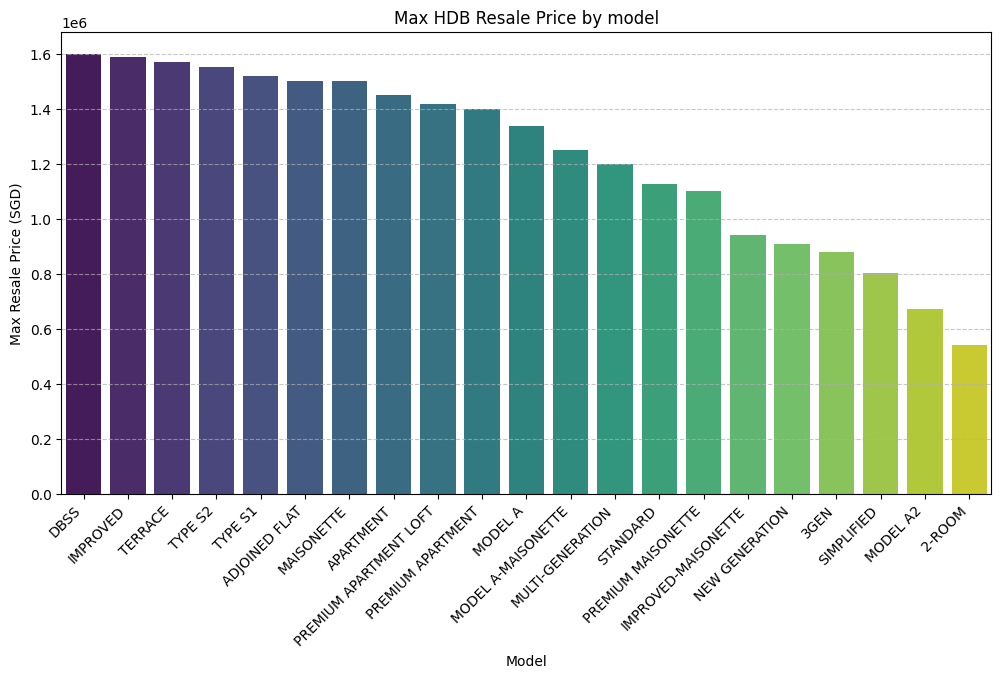

In [17]:
max_price_models = df.groupby("flat_model")["resale_price"].max().reset_index()

max_price_models = max_price_models.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_price_models, x="flat_model", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max HDB Resale Price by model")
plt.xlabel("Model")
plt.ylabel("Max Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/3841027202.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_price_types, x="flat_type", y="resale_price", palette="viridis")


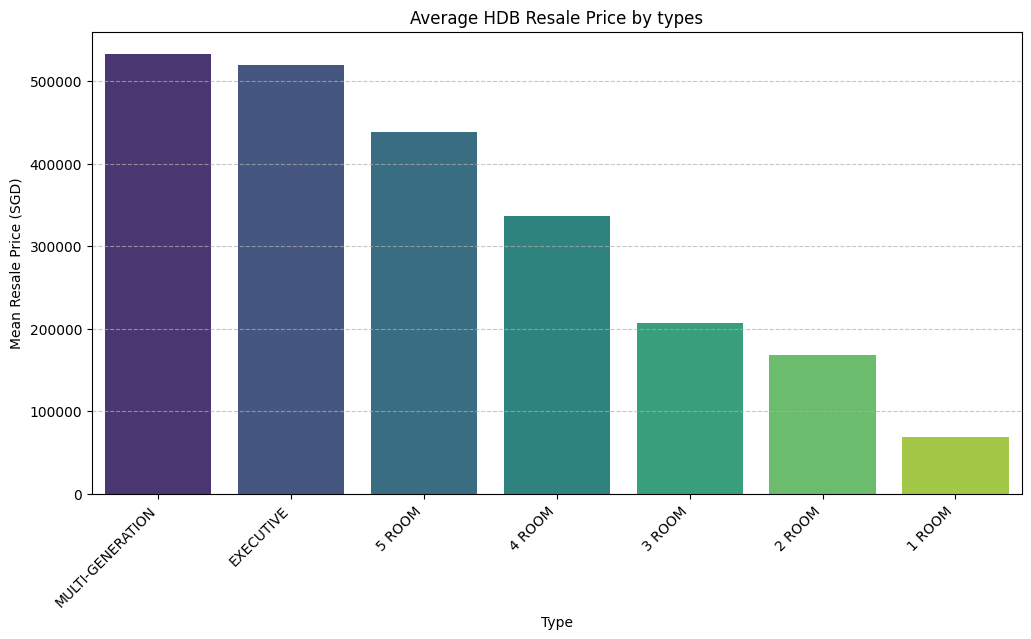

In [18]:
mean_price_types = df.groupby("flat_type")["resale_price"].mean().reset_index()

mean_price_types = mean_price_types.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_price_types, x="flat_type", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average HDB Resale Price by types")
plt.xlabel("Type")
plt.ylabel("Mean Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/1791567037.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_price_types, x="flat_type", y="resale_price", palette="viridis")


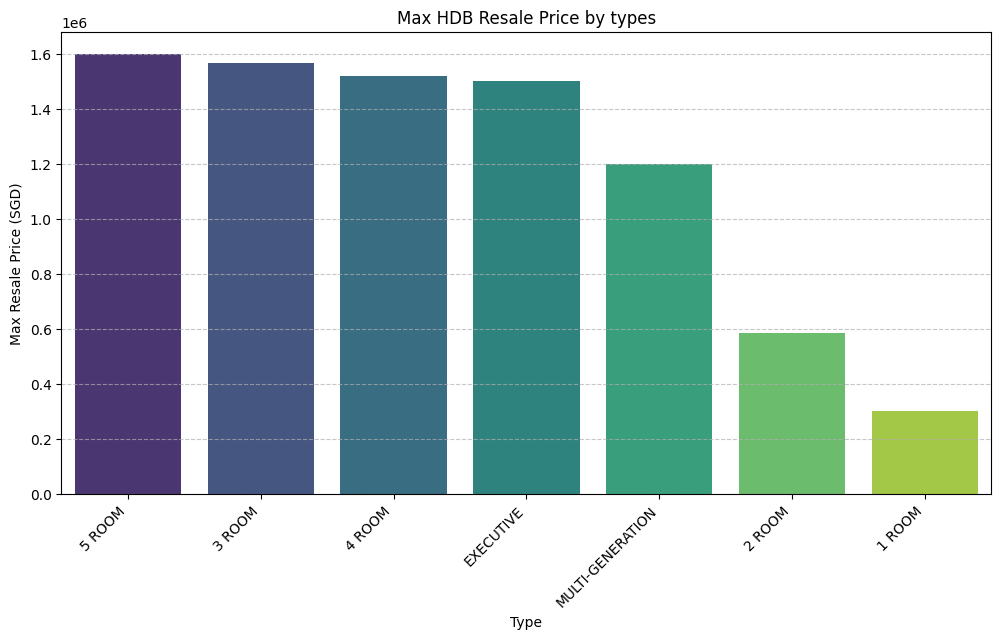

In [19]:
max_price_types = df.groupby("flat_type")["resale_price"].max().reset_index()

max_price_types = max_price_types.sort_values(by="resale_price", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_price_types, x="flat_type", y="resale_price", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max HDB Resale Price by types")
plt.xlabel("Type")
plt.ylabel("Max Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

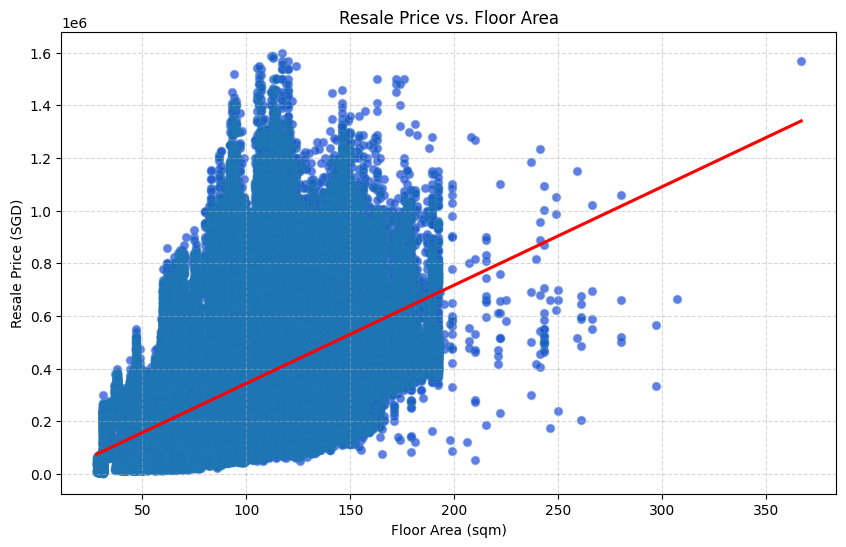

In [20]:
# Set figure size
plt.figure(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(data=df, x="floor_area_sqm", y="resale_price", alpha=0.5, color="blue")
sns.regplot(data=df, x="floor_area_sqm", y="resale_price", scatter_kws={"alpha": 0.3}, line_kws={"color": "red"})

# Add labels and title
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Resale Price (SGD)")
plt.title("Resale Price vs. Floor Area")
plt.grid(True, linestyle="--", alpha=0.5)

# Show plot
plt.show()

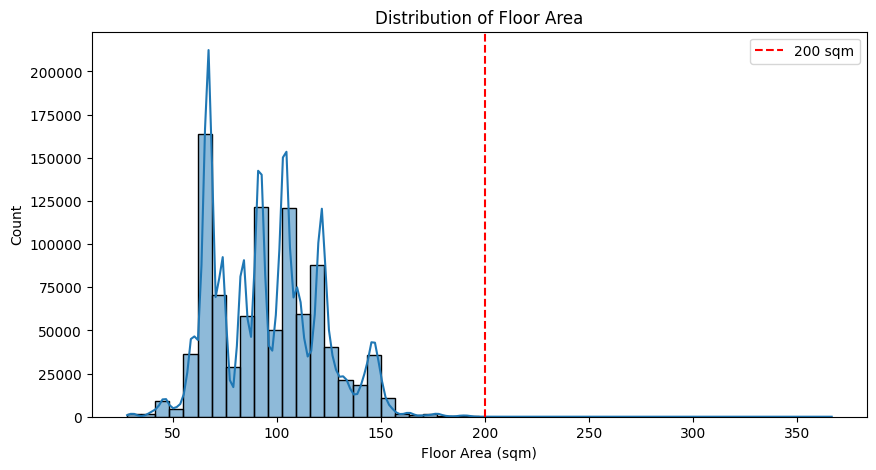

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(df["floor_area_sqm"], bins=50, kde=True)
plt.axvline(200, color="red", linestyle="--", label="200 sqm")
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Count")
plt.title("Distribution of Floor Area")
plt.legend()
plt.show()


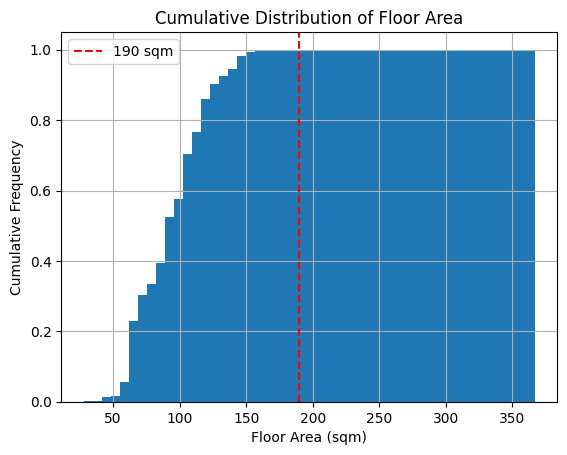

In [22]:
df["floor_area_sqm"].hist(cumulative=True, bins=50, density=True)
plt.xlabel("Floor Area (sqm)")
plt.ylabel("Cumulative Frequency")
plt.title("Cumulative Distribution of Floor Area")
plt.axvline(190, color="red", linestyle="--", label="190 sqm")
plt.legend()
plt.show()

In [23]:
# Calculate the cumulative frequency at 190 sqm
cumfreq_at_190 = (df["floor_area_sqm"] <= 180).mean()
print(f"Cumulative frequency at 190 sqm: {cumfreq_at_190:.4f}")

Cumulative frequency at 190 sqm: 0.9989


In [24]:
print(df["floor_area_sqm"].value_counts().to_string())

floor_area_sqm
67.0     70423
104.0    47827
68.0     41227
84.0     36573
92.0     31917
121.0    30019
73.0     28582
91.0     27504
93.0     27313
65.0     27041
103.0    26841
110.0    26265
122.0    24428
74.0     24277
90.0     17932
105.0    17351
82.0     16739
64.0     14933
59.0     14395
100.0    13536
120.0    13250
146.0    13040
60.0     12337
123.0    11189
101.0    10504
106.0    10407
102.0     9399
107.0     7804
113.0     7753
111.0     7421
108.0     7202
117.0     6982
119.0     6972
94.0      6618
112.0     6504
66.0      6492
118.0     6296
125.0     6138
83.0      6004
88.0      5980
95.0      5824
126.0     5703
124.0     5451
148.0     5419
115.0     5413
127.0     5346
98.0      5331
69.0      5185
147.0     5086
56.0      4924
85.0      4871
128.0     4804
142.0     4634
75.0      4573
70.0      4432
89.0      4428
99.0      4404
150.0     4394
149.0     4364
133.0     4321
76.0      4318
145.0     4234
96.0      3965
132.0     3904
144.0     3844
143.0     

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/1269994500.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="year", y="resale_price", estimator="mean", ci=None)


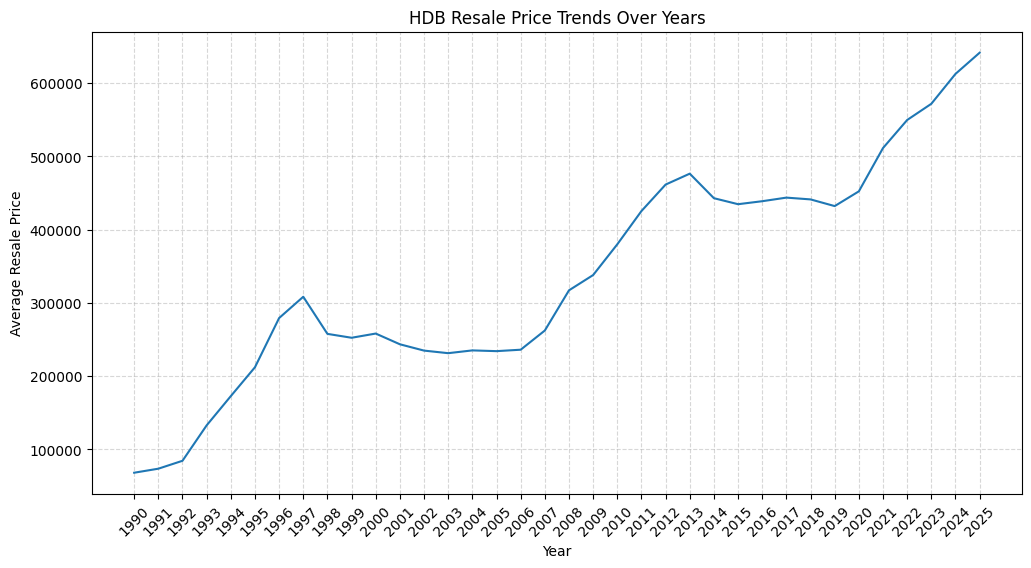

In [25]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="year", y="resale_price", estimator="mean", ci=None)
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Average Resale Price")
plt.title("HDB Resale Price Trends Over Years")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/804481909.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="year", y="resale_price", estimator="max", ci=None)


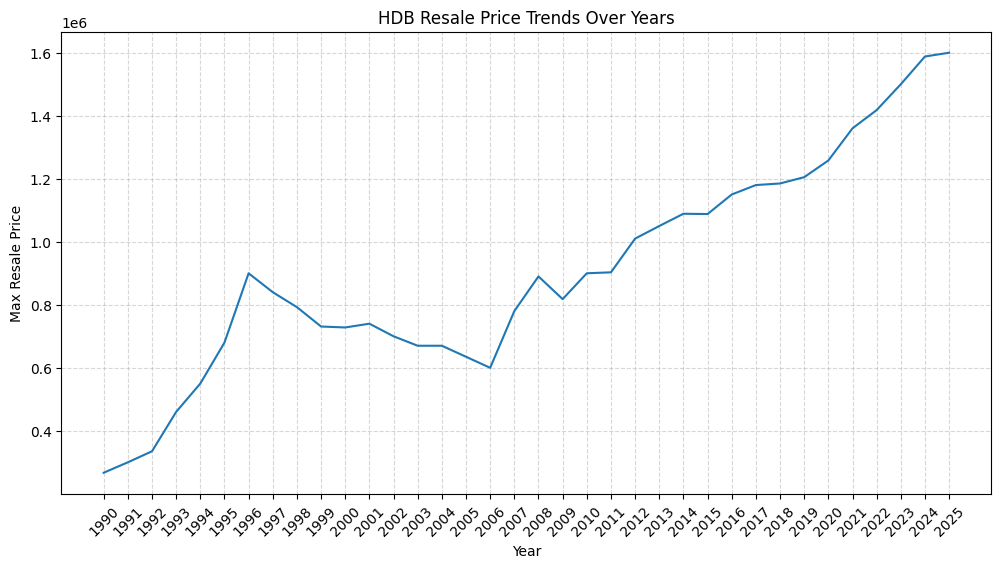

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="year", y="resale_price", estimator="max", ci=None)
plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Max Resale Price")
plt.title("HDB Resale Price Trends Over Years")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/422492354.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="month", y="resale_price", estimator="mean", ci=None)


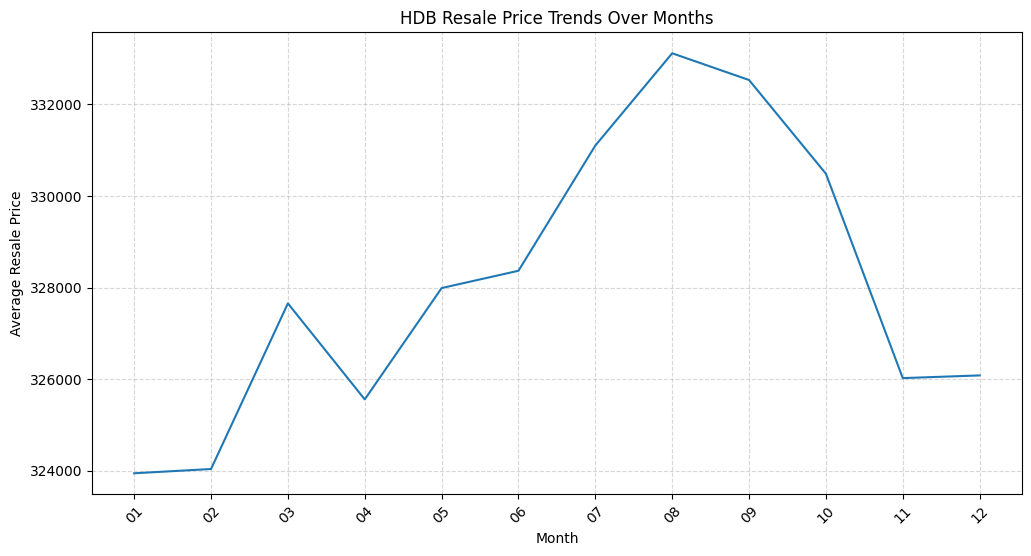

In [27]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="month", y="resale_price", estimator="mean", ci=None)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Average Resale Price")
plt.title("HDB Resale Price Trends Over Months")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/1308897692.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x="month", y="resale_price", estimator="max", ci=None)


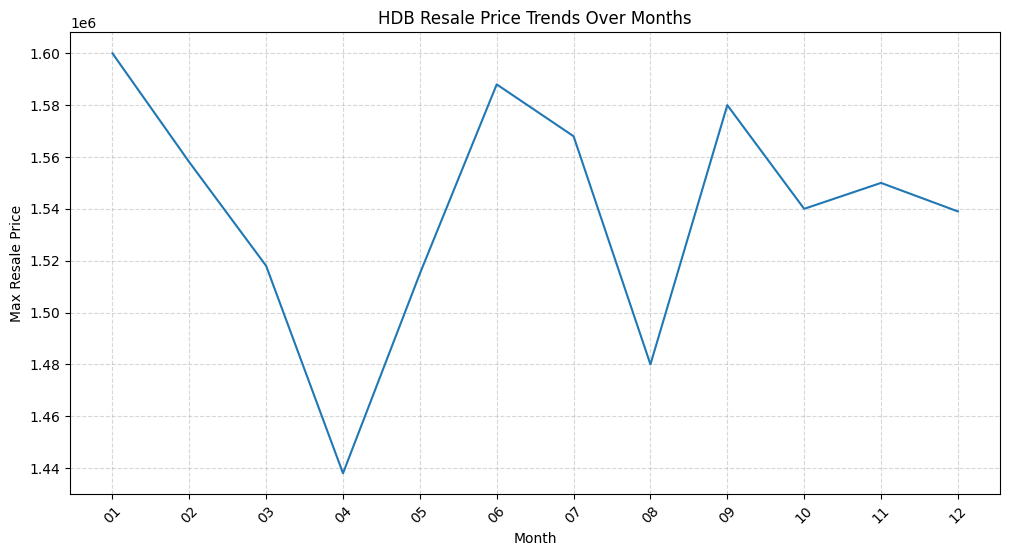

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="month", y="resale_price", estimator="max", ci=None)
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Max Resale Price")
plt.title("HDB Resale Price Trends Over Months")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

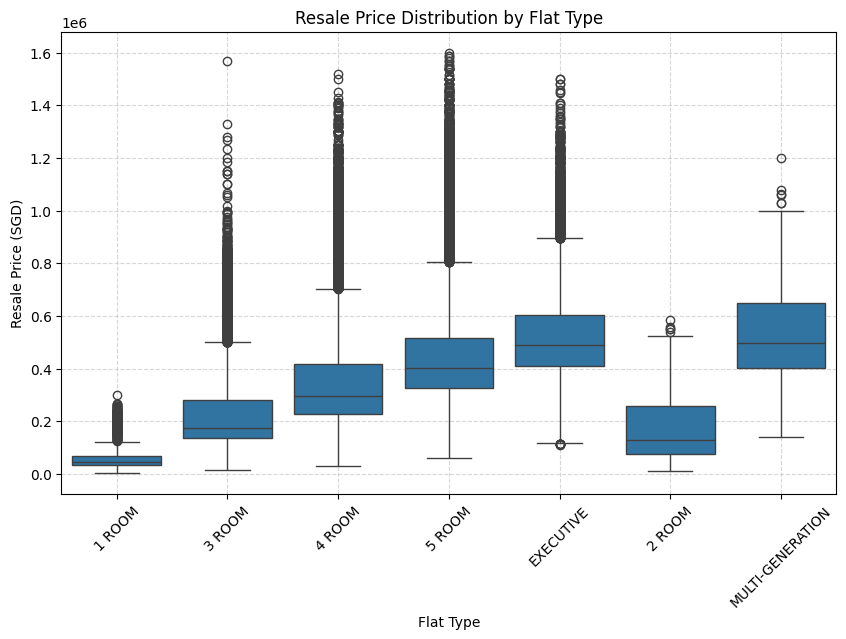

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="flat_type", y="resale_price")
plt.xticks(rotation=45)
plt.xlabel("Flat Type")
plt.ylabel("Resale Price (SGD)")
plt.title("Resale Price Distribution by Flat Type")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

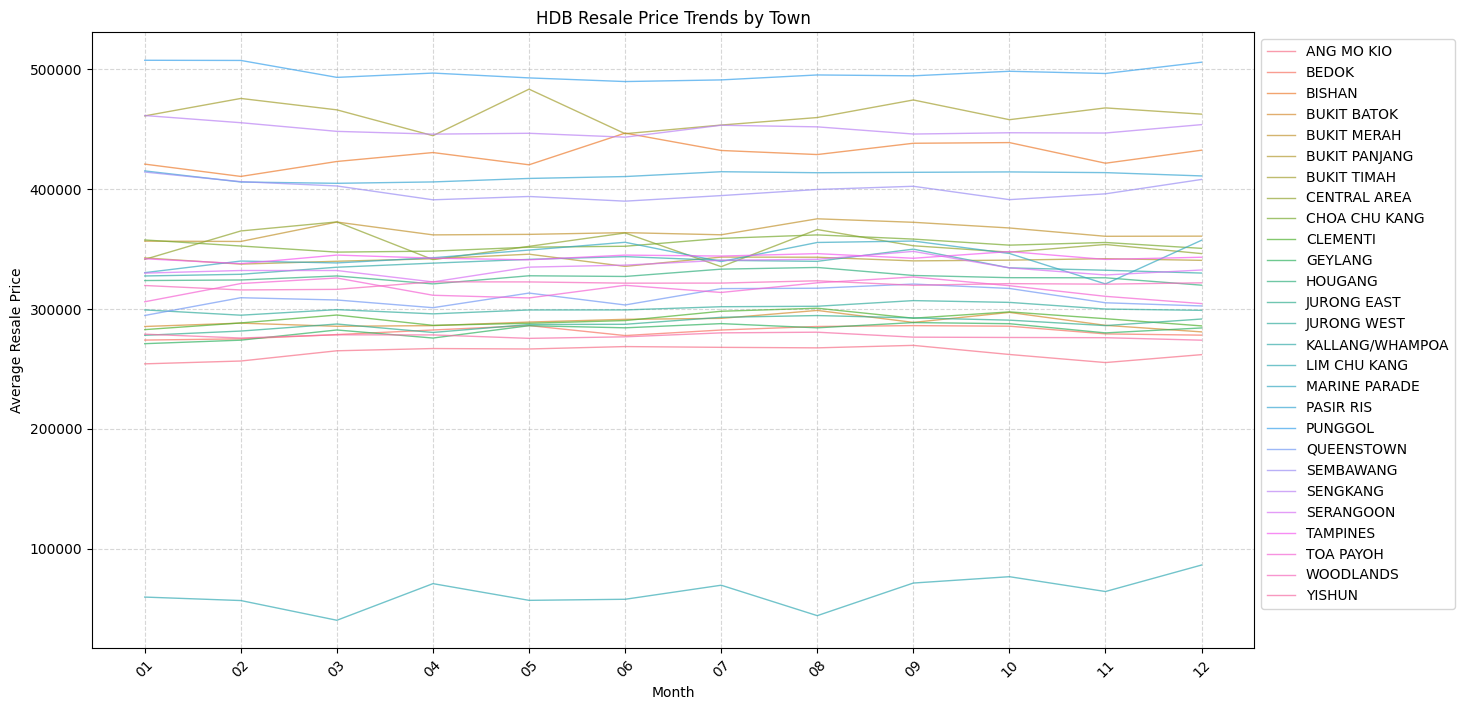

In [30]:
plt.figure(figsize=(15, 8))
town_trends = df.groupby(["month", "town"])["resale_price"].mean().reset_index()
sns.lineplot(data=town_trends, x="month", y="resale_price", hue="town", alpha=0.7, linewidth=1)

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Average Resale Price")
plt.title("HDB Resale Price Trends by Town")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), ncol=1)
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

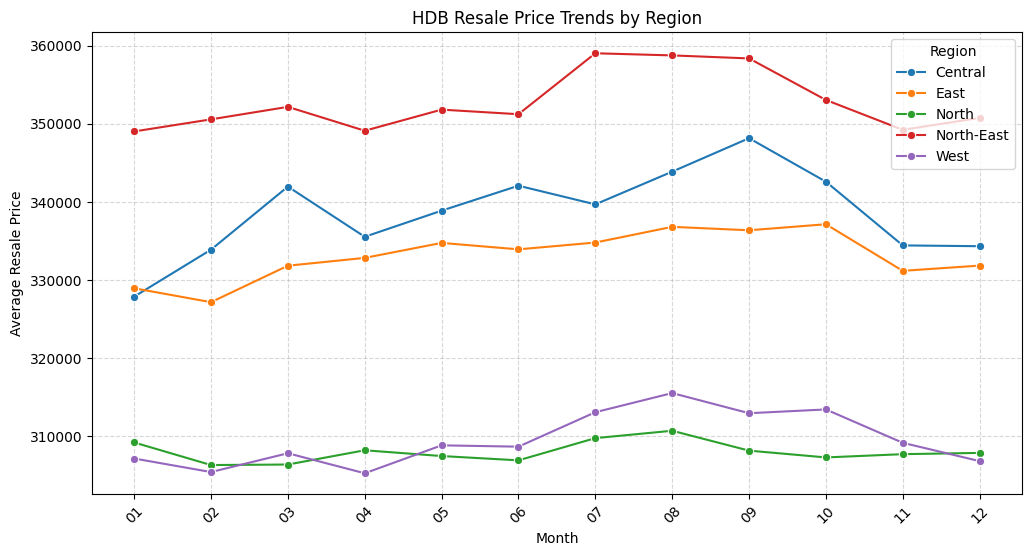

In [31]:
plt.figure(figsize=(12, 6))
region_trends = df.groupby(["month", "region"])["resale_price"].mean().reset_index()
sns.lineplot(data=region_trends, x="month", y="resale_price", hue="region", marker="o")

plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Average Resale Price")
plt.title("HDB Resale Price Trends by Region")
plt.legend(title="Region")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

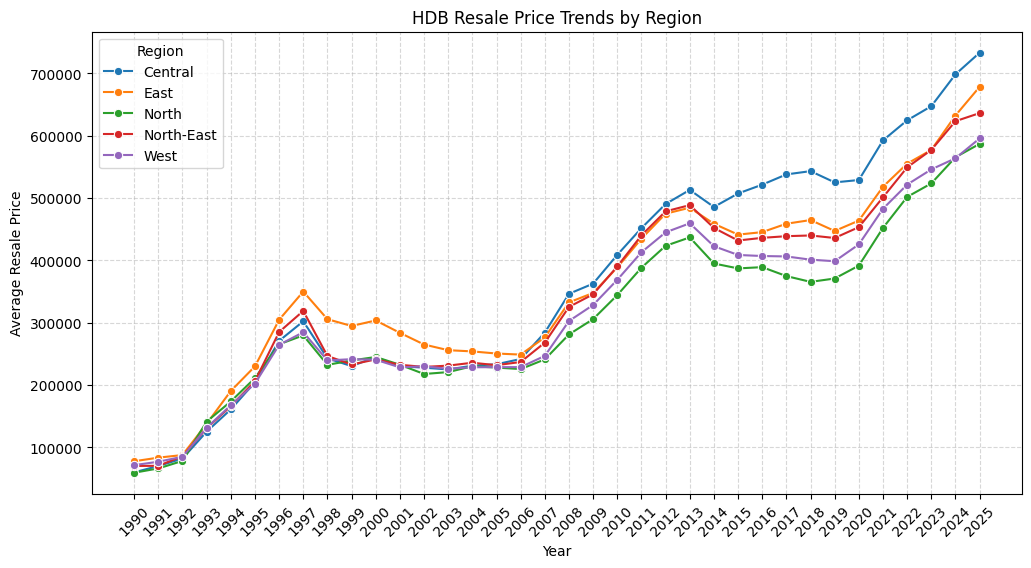

In [32]:
plt.figure(figsize=(12, 6))
region_trends = df.groupby(["year", "region"])["resale_price"].mean().reset_index()
sns.lineplot(data=region_trends, x="year", y="resale_price", hue="region", marker="o")

plt.xticks(rotation=45)
plt.xlabel("Year")
plt.ylabel("Average Resale Price")
plt.title("HDB Resale Price Trends by Region")
plt.legend(title="Region")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

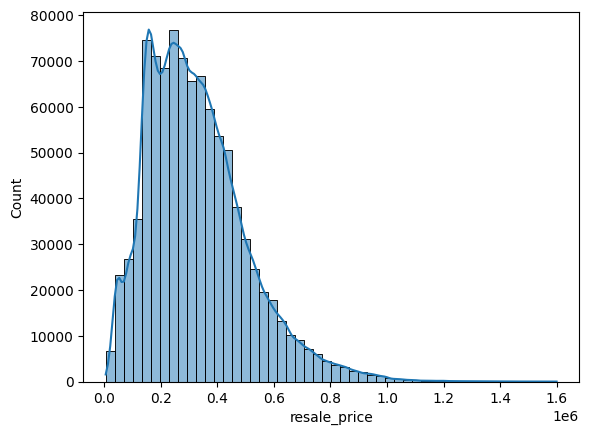

In [33]:
sns.histplot(df["resale_price"], bins=50, kde=True)
plt.show()

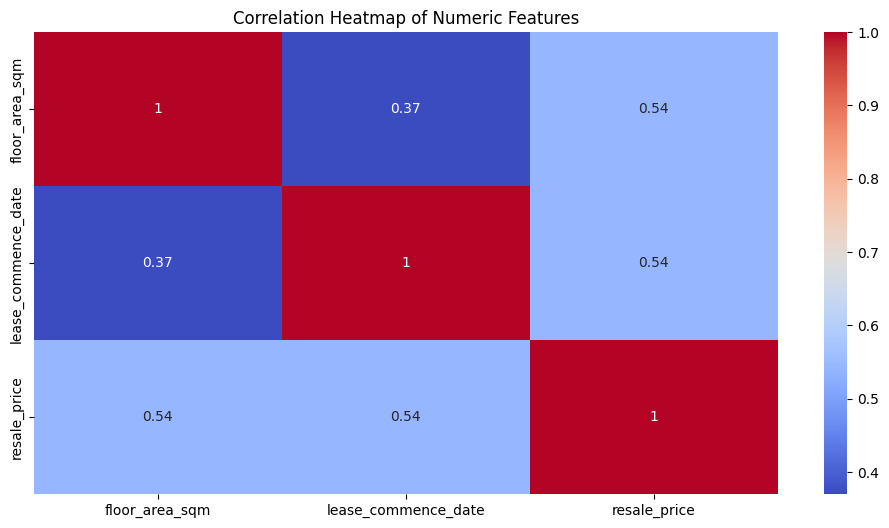

In [34]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.select_dtypes(include=["number"]).corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

In [35]:
# Get the first and last average price for each town
price_change_town = df.groupby("town")["resale_price"].agg(["first", "last"])
price_change_town["percentage_change"] = ((price_change_town["last"] - price_change_town["first"]) / price_change_town["first"]) * 100

# Sort by appreciation/depreciation
price_change_town = price_change_town.sort_values(by="percentage_change", ascending=False)
print(price_change_town)

                    first       last  percentage_change
town                                                   
ANG MO KIO         9000.0   520000.0        5677.777778
GEYLANG           18900.0   500000.0        2545.502646
SEMBAWANG         21300.0   556888.0        2514.497653
QUEENSTOWN        35000.0   838786.0        2296.531429
BUKIT MERAH       51000.0   935000.0        1733.333333
KALLANG/WHAMPOA   31400.0   565000.0        1699.363057
WOODLANDS         38400.0   680000.0        1670.833333
SENGKANG          58000.0   818000.0        1310.344828
SERANGOON         44500.0   600000.0        1248.314607
BUKIT BATOK       57000.0   720000.0        1163.157895
BUKIT TIMAH       85000.0   960888.0        1030.456471
PASIR RIS        100000.0   920000.0         820.000000
TOA PAYOH         42500.0   297000.0         598.823529
CHOA CHU KANG     90000.0   575000.0         538.888889
MARINE PARADE    143000.0   890000.0         522.377622
BEDOK            104000.0   640000.0         515

In [36]:
region_prices = df.groupby(["month", "region"])["resale_price"].mean().reset_index()
price_change_region = region_prices.groupby("region")["resale_price"].agg(["first", "last"]).reset_index()
price_change_region["percentage_change"] = ((price_change_region["last"] - price_change_region["first"]) /
                                             price_change_region["first"]) * 100
price_change_region = price_change_region.sort_values(by="percentage_change", ascending=False)
print(price_change_region)

       region          first           last  percentage_change
0     Central  327864.766996  334326.451921           1.970838
1        East  328934.541967  331841.388798           0.883716
3  North-East  349034.583513  350768.010628           0.496635
4        West  307114.776271  306779.573987          -0.109146
2       North  309171.517543  307835.193512          -0.432227


/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/3780909784.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_area_region, x="region", y="floor_area_sqm", palette="viridis")


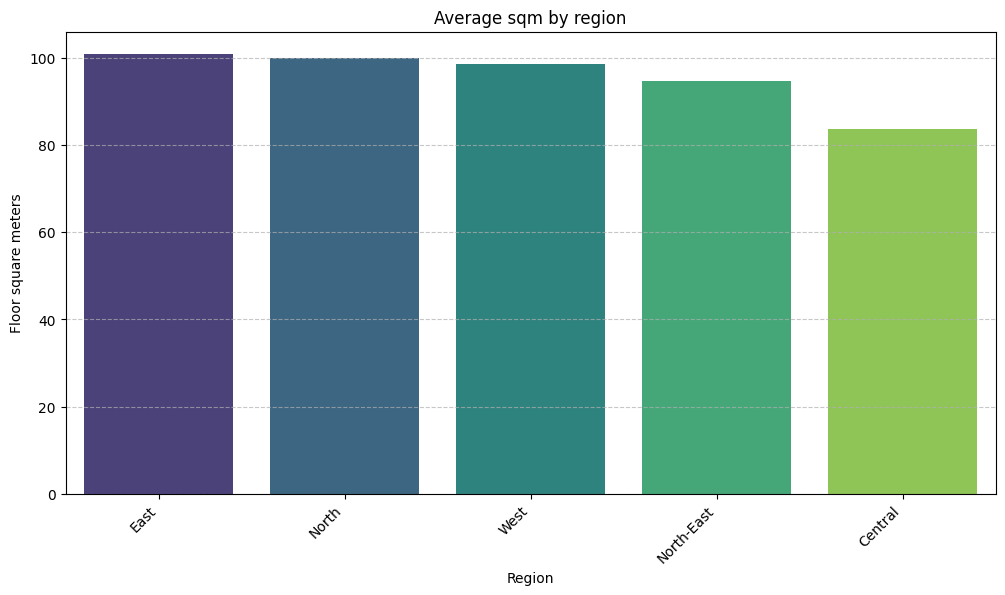

In [37]:
mean_area_region = df.groupby("region")["floor_area_sqm"].mean().reset_index()

mean_area_region = mean_area_region.sort_values(by="floor_area_sqm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_area_region, x="region", y="floor_area_sqm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average sqm by region")
plt.xlabel("Region")
plt.ylabel("Floor square meters")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/3418026984.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_area_region, x="region", y="floor_area_sqm", palette="viridis")


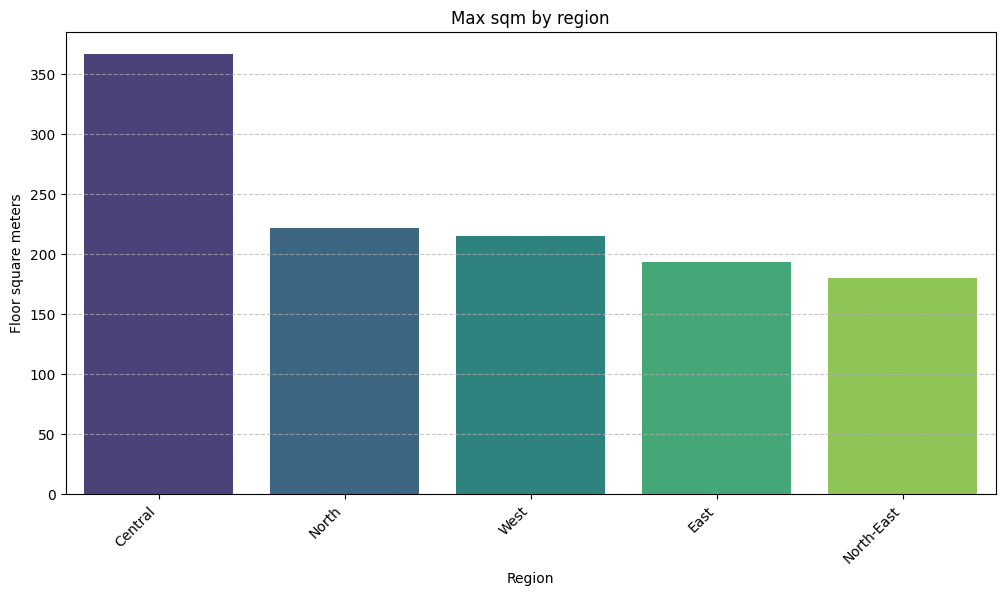

In [38]:
max_area_region = df.groupby("region")["floor_area_sqm"].max().reset_index()

max_area_region = max_area_region.sort_values(by="floor_area_sqm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_area_region, x="region", y="floor_area_sqm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max sqm by region")
plt.xlabel("Region")
plt.ylabel("Floor square meters")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/436883108.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_area_type, x="flat_type", y="floor_area_sqm", palette="viridis")


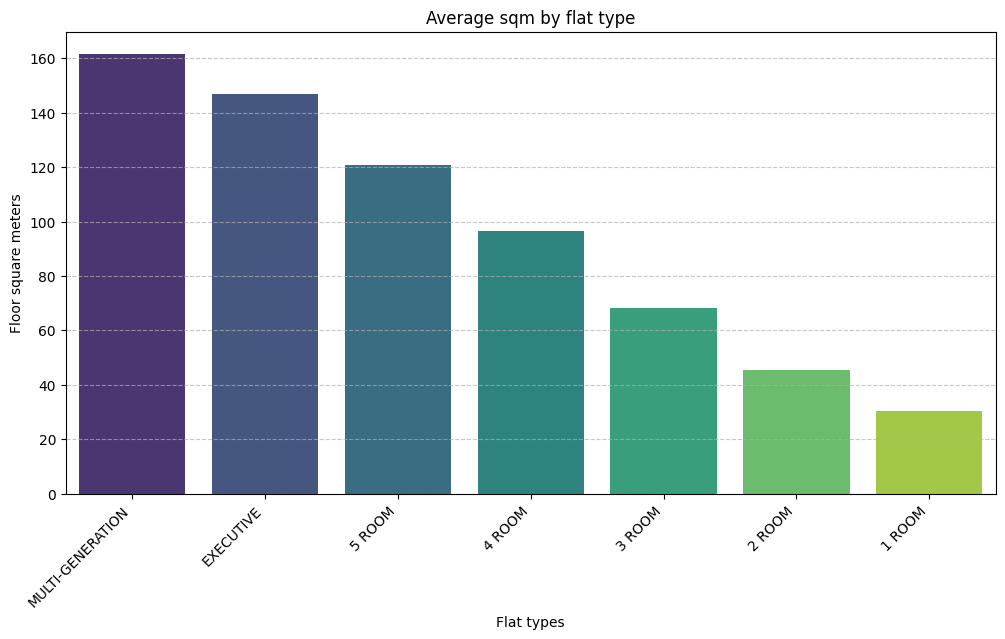

In [39]:
mean_area_type = df.groupby("flat_type")["floor_area_sqm"].mean().reset_index()

mean_area_type = mean_area_type.sort_values(by="floor_area_sqm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_area_type, x="flat_type", y="floor_area_sqm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average sqm by flat type")
plt.xlabel("Flat types")
plt.ylabel("Floor square meters")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/927272251.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_area_type, x="flat_type", y="floor_area_sqm", palette="viridis")


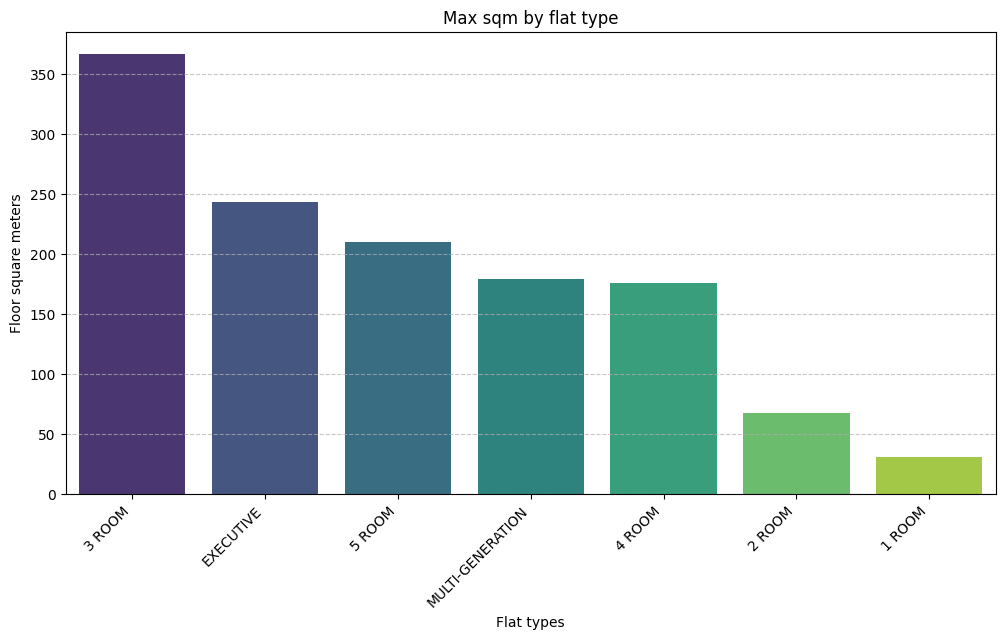

In [40]:
max_area_type = df.groupby("flat_type")["floor_area_sqm"].max().reset_index()

max_area_type = max_area_type.sort_values(by="floor_area_sqm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_area_type, x="flat_type", y="floor_area_sqm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max sqm by flat type")
plt.xlabel("Flat types")
plt.ylabel("Floor square meters")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/4236628752.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_area_model, x="flat_model", y="floor_area_sqm", palette="viridis")


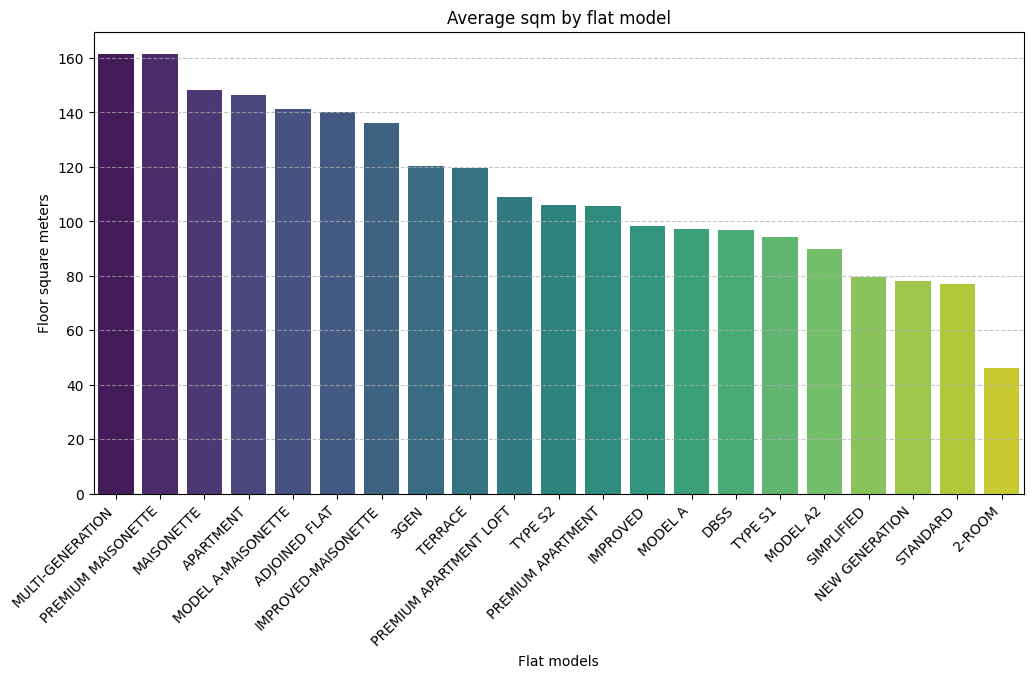

In [41]:
mean_area_model = df.groupby("flat_model")["floor_area_sqm"].mean().reset_index()

mean_area_model = mean_area_model.sort_values(by="floor_area_sqm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_area_model, x="flat_model", y="floor_area_sqm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average sqm by flat model")
plt.xlabel("Flat models")
plt.ylabel("Floor square meters")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/3617675522.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_area_model, x="flat_model", y="floor_area_sqm", palette="viridis")


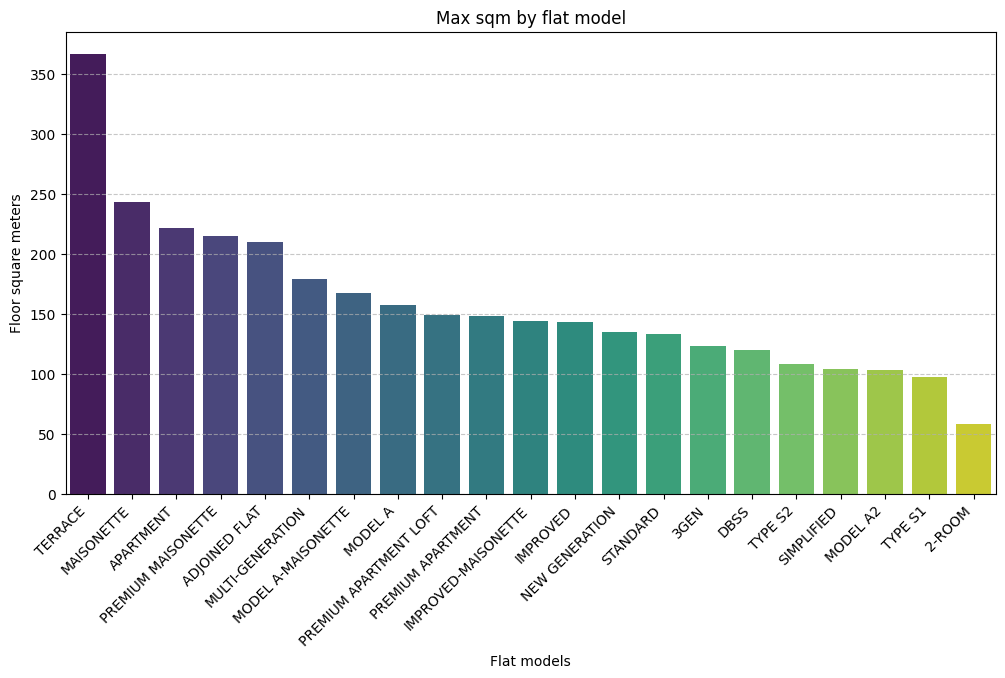

In [42]:
max_area_model = df.groupby("flat_model")["floor_area_sqm"].max().reset_index()

max_area_model = max_area_model.sort_values(by="floor_area_sqm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_area_model, x="flat_model", y="floor_area_sqm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max sqm by flat model")
plt.xlabel("Flat models")
plt.ylabel("Floor square meters")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

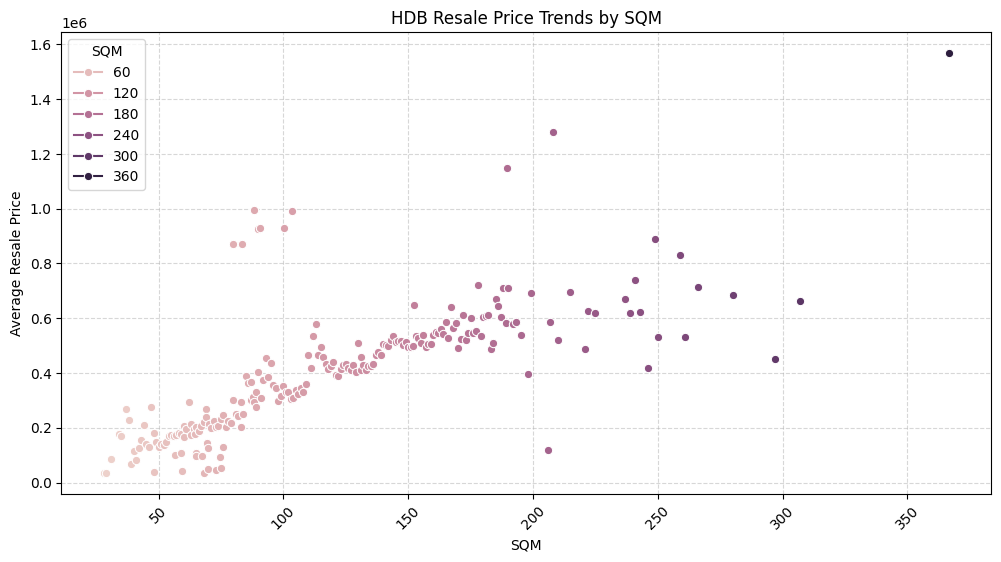

In [43]:
plt.figure(figsize=(12, 6))
price_trends = df.groupby(["floor_area_sqm"])["resale_price"].mean().reset_index()
sns.lineplot(data=price_trends, x="floor_area_sqm", y="resale_price", hue="floor_area_sqm", marker="o")

plt.xticks(rotation=45)
plt.xlabel("SQM")
plt.ylabel("Average Resale Price")
plt.title("HDB Resale Price Trends by SQM")
plt.legend(title="SQM")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

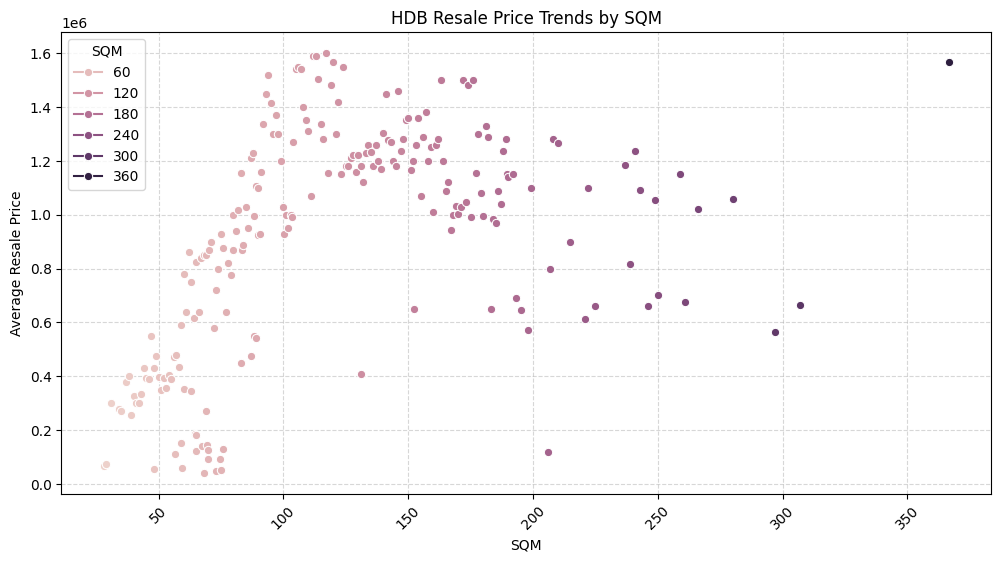

In [44]:
plt.figure(figsize=(12, 6))
price_trends = df.groupby(["floor_area_sqm"])["resale_price"].max().reset_index()
sns.lineplot(data=price_trends, x="floor_area_sqm", y="resale_price", hue="floor_area_sqm", marker="o")

plt.xticks(rotation=45)
plt.xlabel("SQM")
plt.ylabel("Average Resale Price")
plt.title("HDB Resale Price Trends by SQM")
plt.legend(title="SQM")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [45]:
# Find the SQM with the highest average resale price
max_price_row = price_trends.loc[price_trends['resale_price'].idxmax()]
max_price_sqm = max_price_row.name  # The index contains the sqm value
max_price = max_price_row['resale_price']

print(f"Highest average resale price: ${max_price:,.2f}")
print(f"At square meters: {max_price_sqm}")

Highest average resale price: $1,600,000.00
At square meters: 115


In [46]:
# Show top 5 highest average prices and their corresponding SQM values
top_prices = price_trends.sort_values('resale_price', ascending=False).head(5)
print("Top 5 highest average resale prices by floor area:")
print(top_prices)

Top 5 highest average resale prices by floor area:
     floor_area_sqm  resale_price
115           117.0     1600000.0
110           112.0     1588000.0
111           113.0     1588000.0
218           366.7     1568000.0
118           120.0     1568000.0


/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/2222567851.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_area_town, x="town", y="floor_area_sqm", palette="viridis")


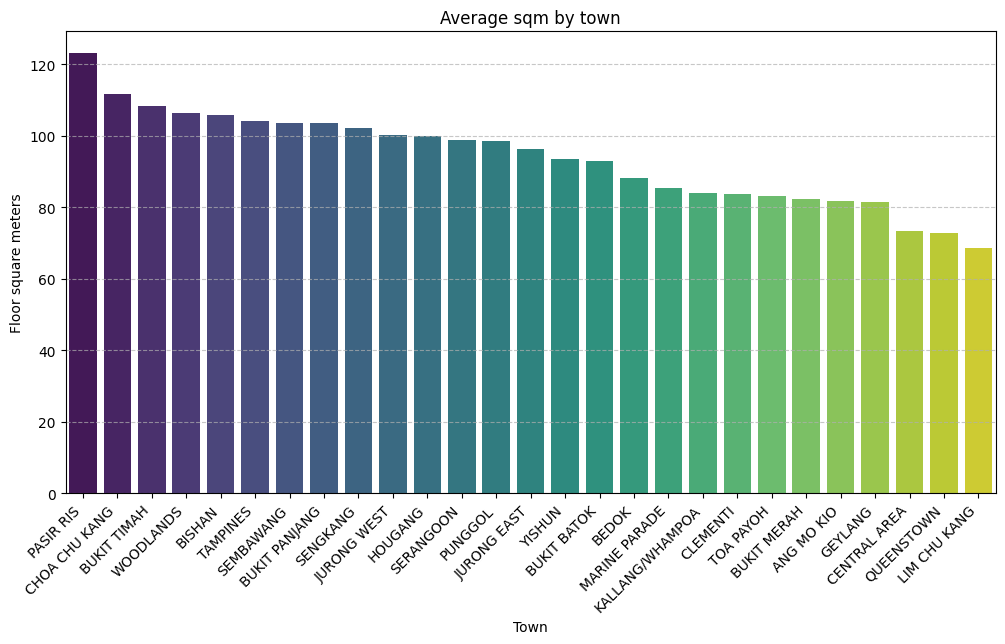

In [47]:
mean_area_town = df.groupby("town")["floor_area_sqm"].mean().reset_index()

mean_area_town = mean_area_town.sort_values(by="floor_area_sqm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_area_town, x="town", y="floor_area_sqm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average sqm by town")
plt.xlabel("Town")
plt.ylabel("Floor square meters")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/18026202.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_area_town, x="town", y="floor_area_sqm", palette="viridis")


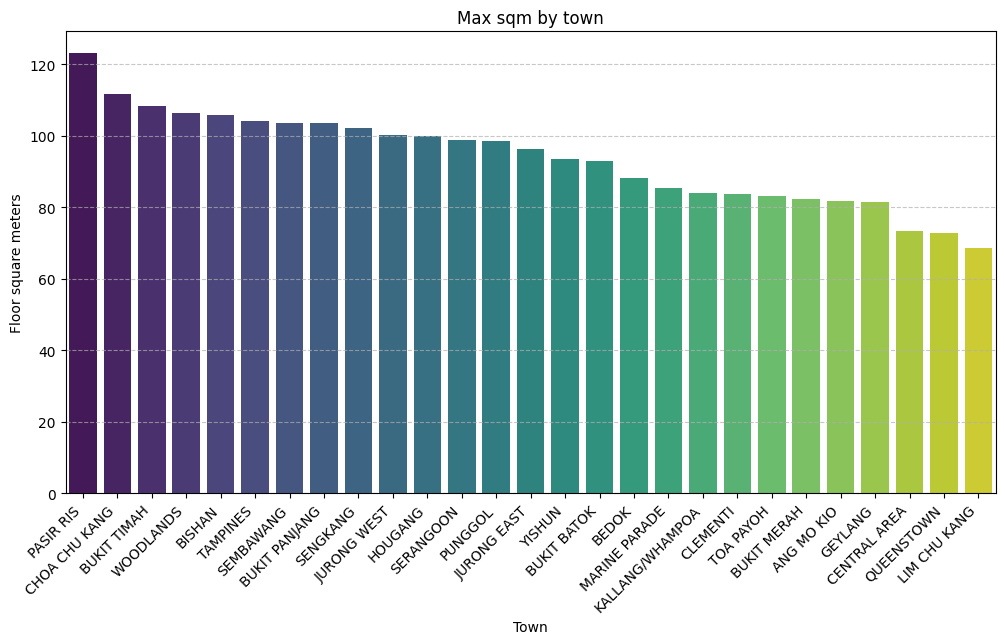

In [48]:
max_area_town = df.groupby("town")["floor_area_sqm"].mean().reset_index()

max_area_town = max_area_town.sort_values(by="floor_area_sqm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_area_town, x="town", y="floor_area_sqm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max sqm by town")
plt.xlabel("Town")
plt.ylabel("Floor square meters")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

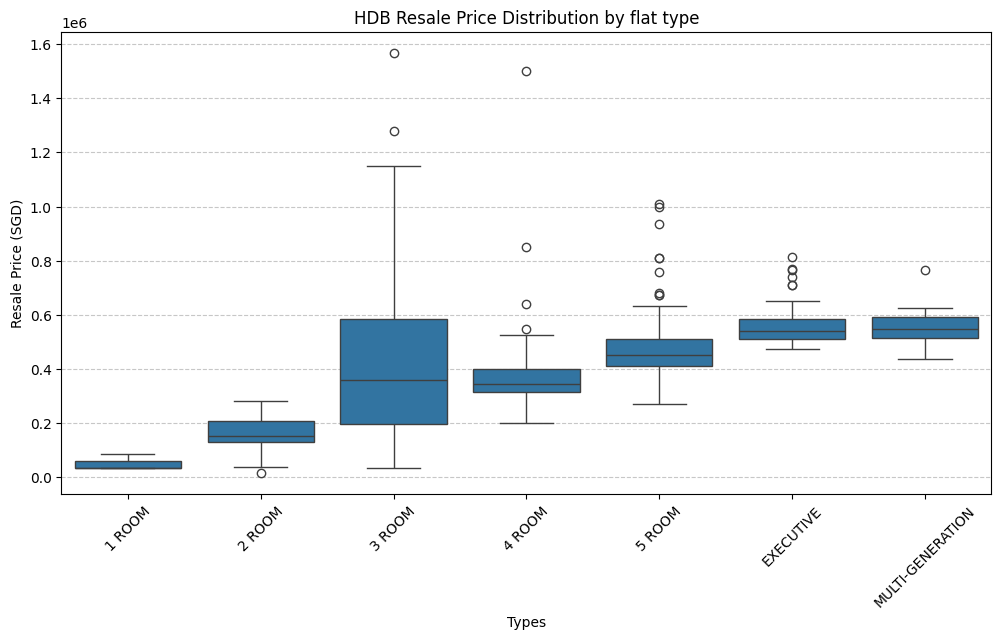

In [49]:
mean_psf = df.groupby(["flat_type", "floor_area_sqm"])["resale_price"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(data=mean_psf, x="flat_type", y="resale_price")
plt.xticks(rotation=45)
plt.title("HDB Resale Price Distribution by flat type")
plt.xlabel("Types")
plt.ylabel("Resale Price (SGD)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

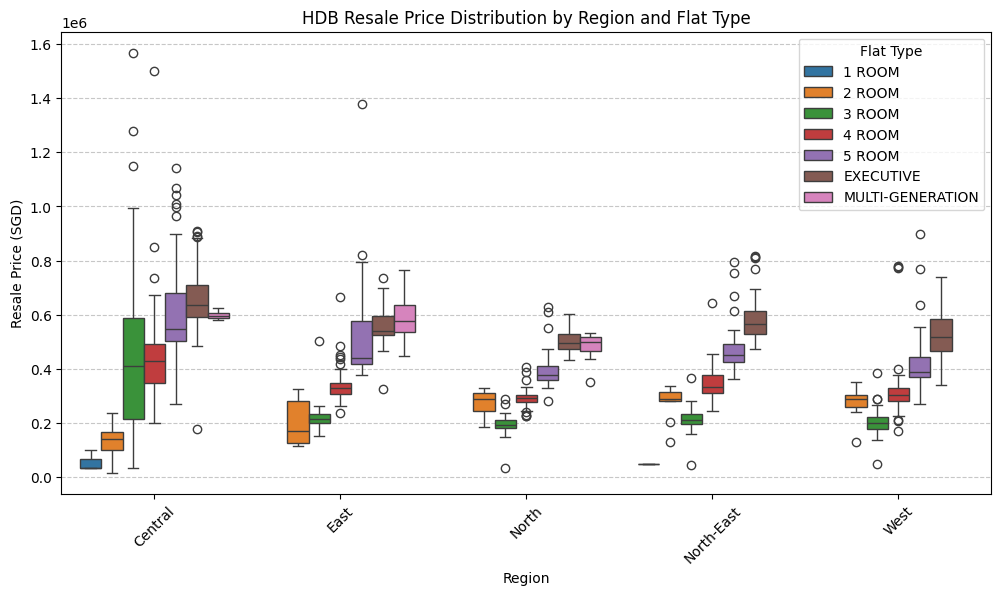

In [50]:
mean_psf_region = df.groupby(["region", "flat_type", "floor_area_sqm"])["resale_price"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.boxplot(data=mean_psf_region, x="region", y="resale_price", hue="flat_type")
plt.xticks(rotation=45)
plt.title("HDB Resale Price Distribution by Region and Flat Type")
plt.xlabel("Region")
plt.ylabel("Resale Price (SGD)")
plt.legend(title="Flat Type")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [52]:
df['psm'] = df['resale_price'] / df['floor_area_sqm']
df

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,day,region,psm
0,01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,1990,01,North-East,290.322581
1,01,KALLANG/WHAMPOA,3 ROOM,44,BENDEMEER RD,04 TO 06,63.0,STANDARD,1981,31400.0,1990,01,Central,498.412698
2,01,KALLANG/WHAMPOA,3 ROOM,20,ST. GEORGE'S RD,04 TO 06,67.0,NEW GENERATION,1984,66500.0,1990,01,Central,992.537313
3,01,KALLANG/WHAMPOA,3 ROOM,14,KG ARANG RD,04 TO 06,103.0,NEW GENERATION,1984,77000.0,1990,01,Central,747.572816
4,01,KALLANG/WHAMPOA,3 ROOM,46,OWEN RD,01 TO 03,68.0,NEW GENERATION,1982,58000.0,1990,01,Central,852.941176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949506,03,TAMPINES,4 ROOM,613A,TAMPINES NTH DR 1,10 TO 12,93.0,MODEL A,2020,795000.0,2025,03,East,8548.387097
949507,03,TAMPINES,4 ROOM,608A,TAMPINES NTH DR 1,04 TO 06,93.0,MODEL A,2020,715000.0,2025,03,East,7688.172043
949508,03,TAMPINES,4 ROOM,609A,TAMPINES NTH DR 1,10 TO 12,93.0,MODEL A,2020,790000.0,2025,03,East,8494.623656
949509,03,TAMPINES,4 ROOM,113,TAMPINES ST 11,04 TO 06,115.0,MODEL A,1982,700000.0,2025,03,East,6086.956522


/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/4000774227.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_psm_region, x="region", y="psm", palette="viridis")


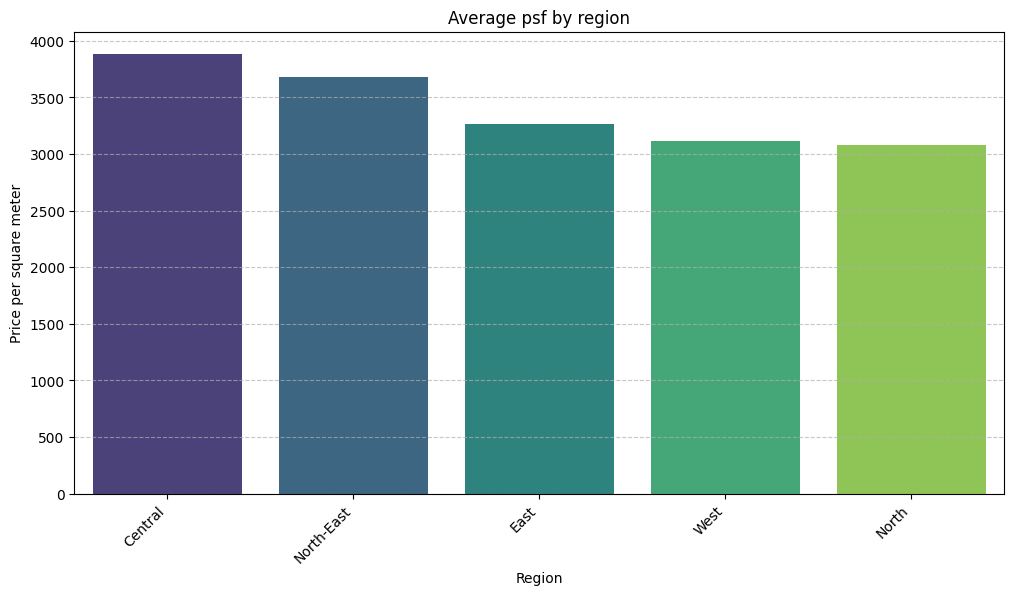

In [53]:
mean_psm_region = df.groupby("region")["psm"].mean().reset_index()

mean_psm_region = mean_psm_region.sort_values(by="psm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_psm_region, x="region", y="psm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average psf by region")
plt.xlabel("Region")
plt.ylabel("Price per square meter")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/1678050787.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_psm_region, x="region", y="psm", palette="viridis")


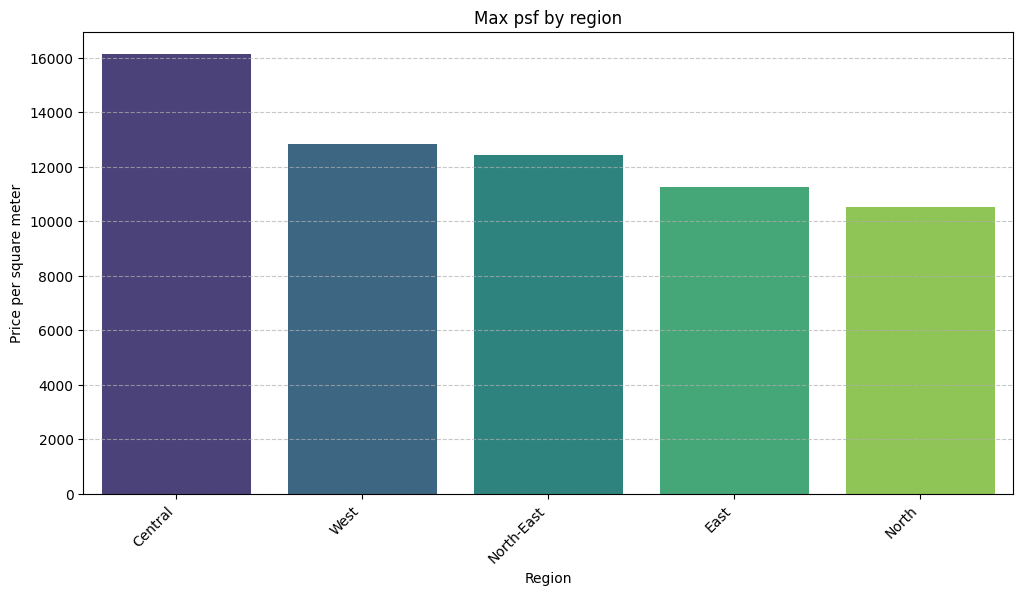

In [54]:
max_psm_region = df.groupby("region")["psm"].max().reset_index()

max_psm_region = max_psm_region.sort_values(by="psm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_psm_region, x="region", y="psm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max psf by region")
plt.xlabel("Region")
plt.ylabel("Price per square meter")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/2112970155.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_psm_type, x="flat_type", y="psm", palette="viridis")


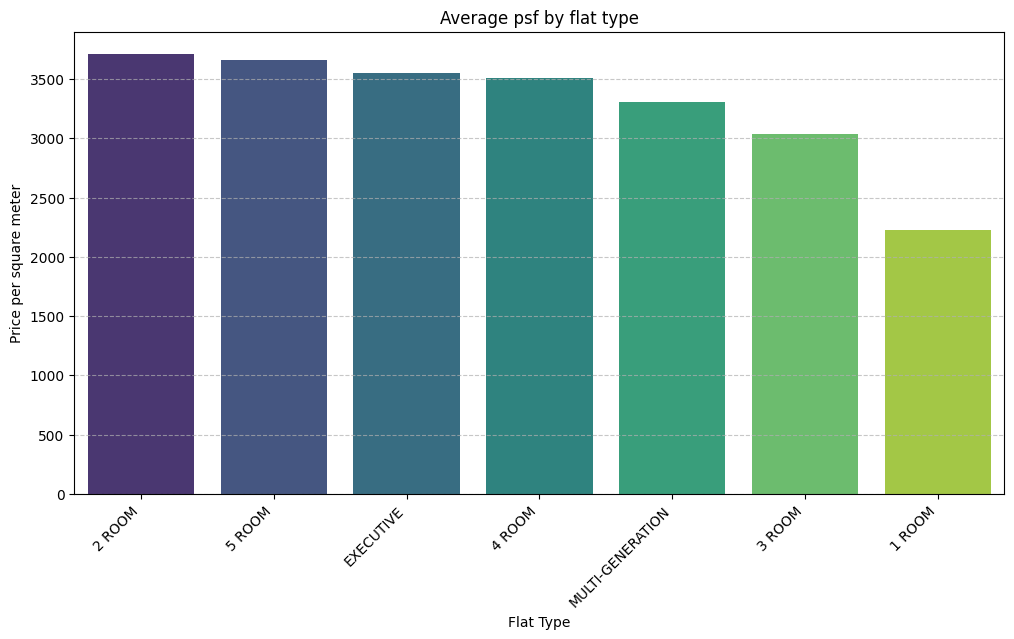

In [55]:
mean_psm_type = df.groupby("flat_type")["psm"].mean().reset_index()

mean_psm_type = mean_psm_type.sort_values(by="psm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_psm_type, x="flat_type", y="psm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average psf by flat type")
plt.xlabel("Flat Type")
plt.ylabel("Price per square meter")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/1221316824.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_psm_type, x="flat_type", y="psm", palette="viridis")


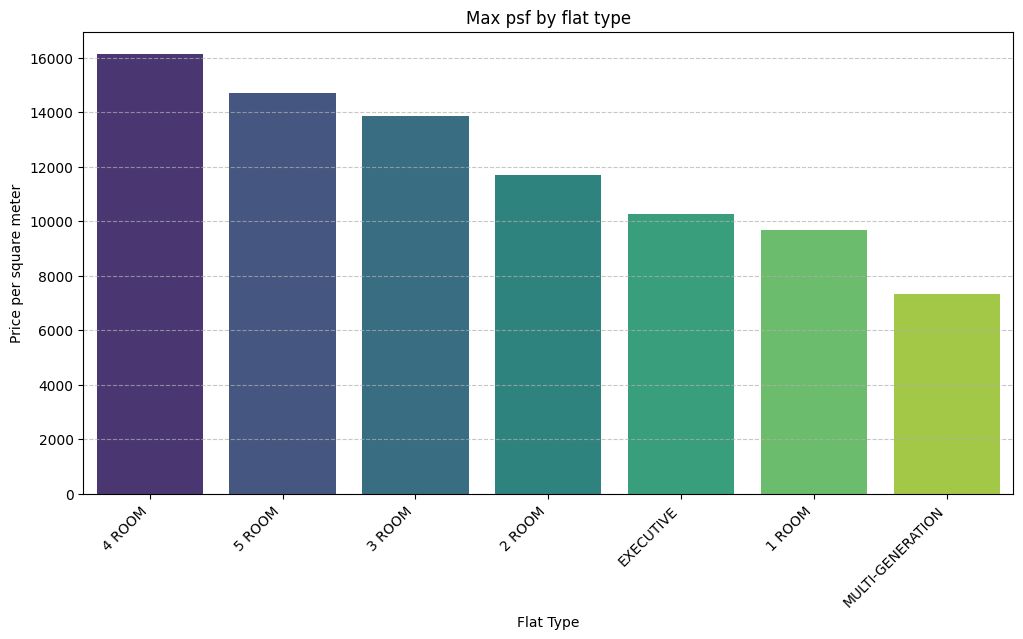

In [56]:
max_psm_type = df.groupby("flat_type")["psm"].max().reset_index()

max_psm_type = max_psm_type.sort_values(by="psm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_psm_type, x="flat_type", y="psm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Max psf by flat type")
plt.xlabel("Flat Type")
plt.ylabel("Price per square meter")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/3996701776.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_psm_model, x="flat_model", y="psm", palette="viridis")


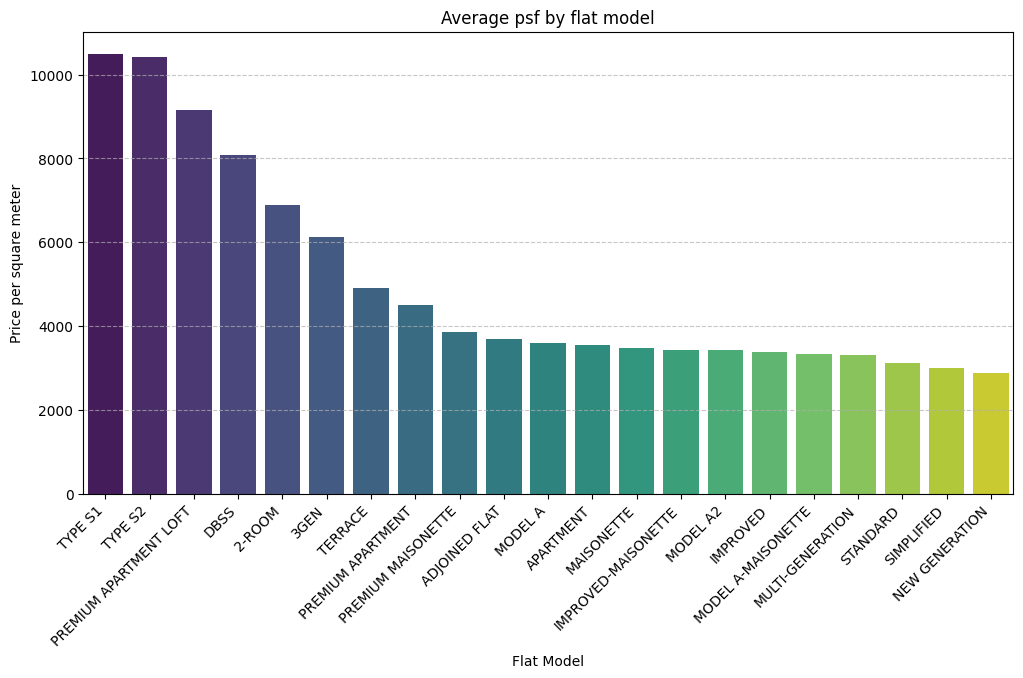

In [57]:
mean_psm_model = df.groupby("flat_model")["psm"].mean().reset_index()

mean_psm_model = mean_psm_model.sort_values(by="psm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=mean_psm_model, x="flat_model", y="psm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average psf by flat model")
plt.xlabel("Flat Model")
plt.ylabel("Price per square meter")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

/var/folders/4_/sjd68t5s6sl23f_13pk7r4240000gn/T/ipykernel_30107/217717036.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=max_psm_model, x="flat_model", y="psm", palette="viridis")


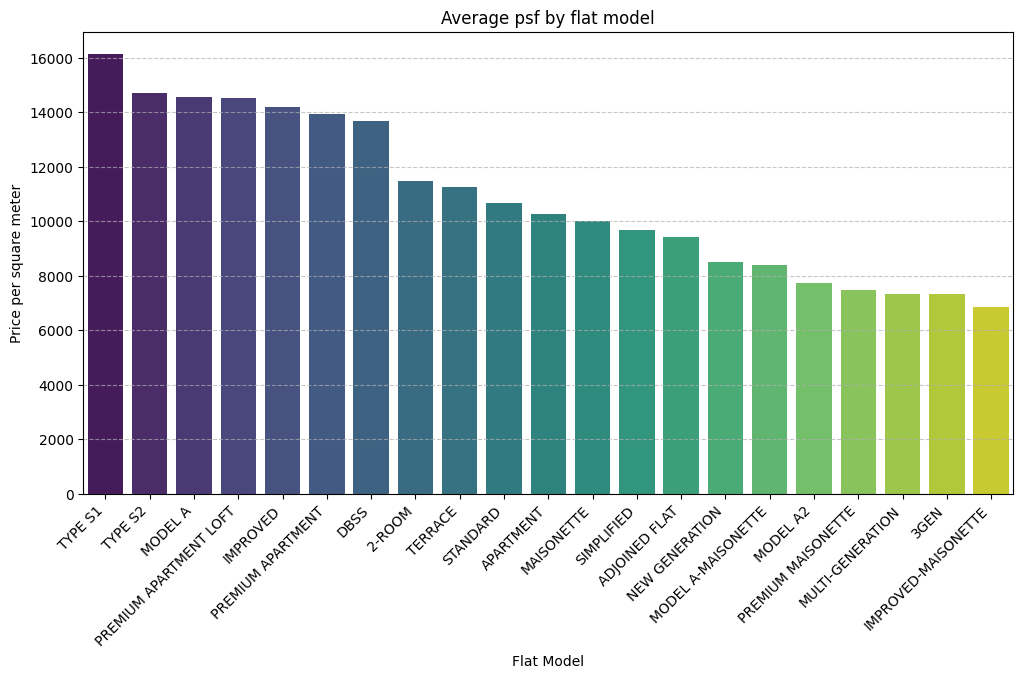

In [58]:
max_psm_model = df.groupby("flat_model")["psm"].max().reset_index()

max_psm_model = max_psm_model.sort_values(by="psm", ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=max_psm_model, x="flat_model", y="psm", palette="viridis")

# Improve readability
plt.xticks(rotation=45, ha="right")
plt.title("Average psf by flat model")
plt.xlabel("Flat Model")
plt.ylabel("Price per square meter")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

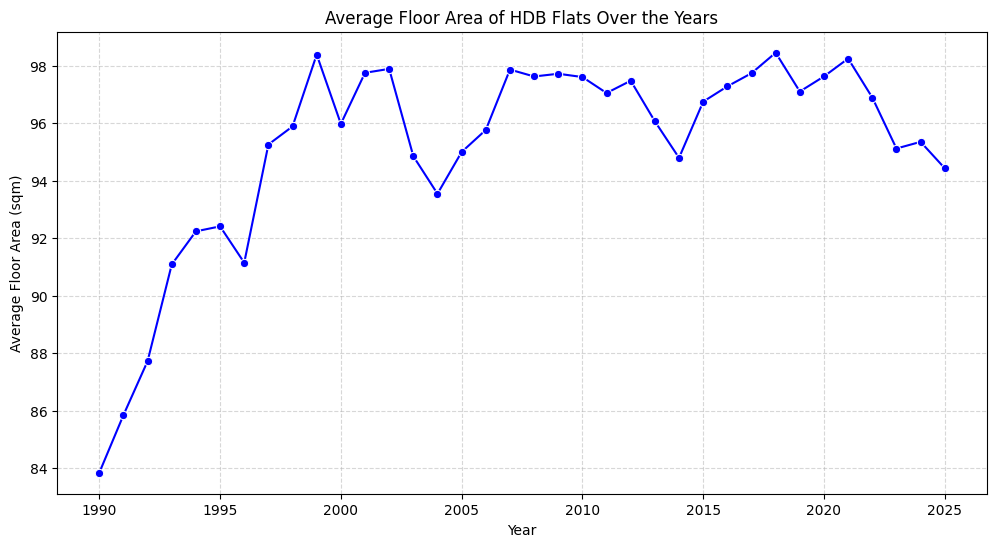

In [59]:
df["year"] = df["year"].astype(int)

# Group by year and compute mean floor area
yearly_floor_area = df.groupby("year")["floor_area_sqm"].mean().reset_index()

# Plot the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_floor_area, x="year", y="floor_area_sqm", marker="o", color="blue")

# Formatting
plt.xlabel("Year")
plt.ylabel("Average Floor Area (sqm)")
plt.title("Average Floor Area of HDB Flats Over the Years")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

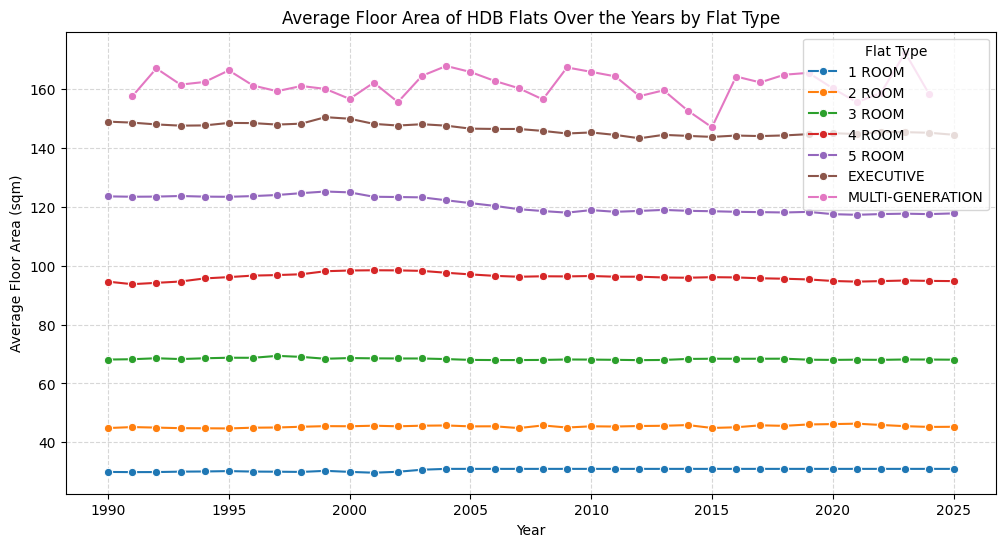

In [60]:
# Group by year and flat_type, then compute mean floor area
yearly_floor_area = df.groupby(["year", "flat_type"])["floor_area_sqm"].mean().reset_index()

# Plot the line graph
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_floor_area, x="year", y="floor_area_sqm", hue="flat_type", marker="o", palette="tab10")

# Formatting
plt.xlabel("Year")
plt.ylabel("Average Floor Area (sqm)")
plt.title("Average Floor Area of HDB Flats Over the Years by Flat Type")
plt.legend(title="Flat Type")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

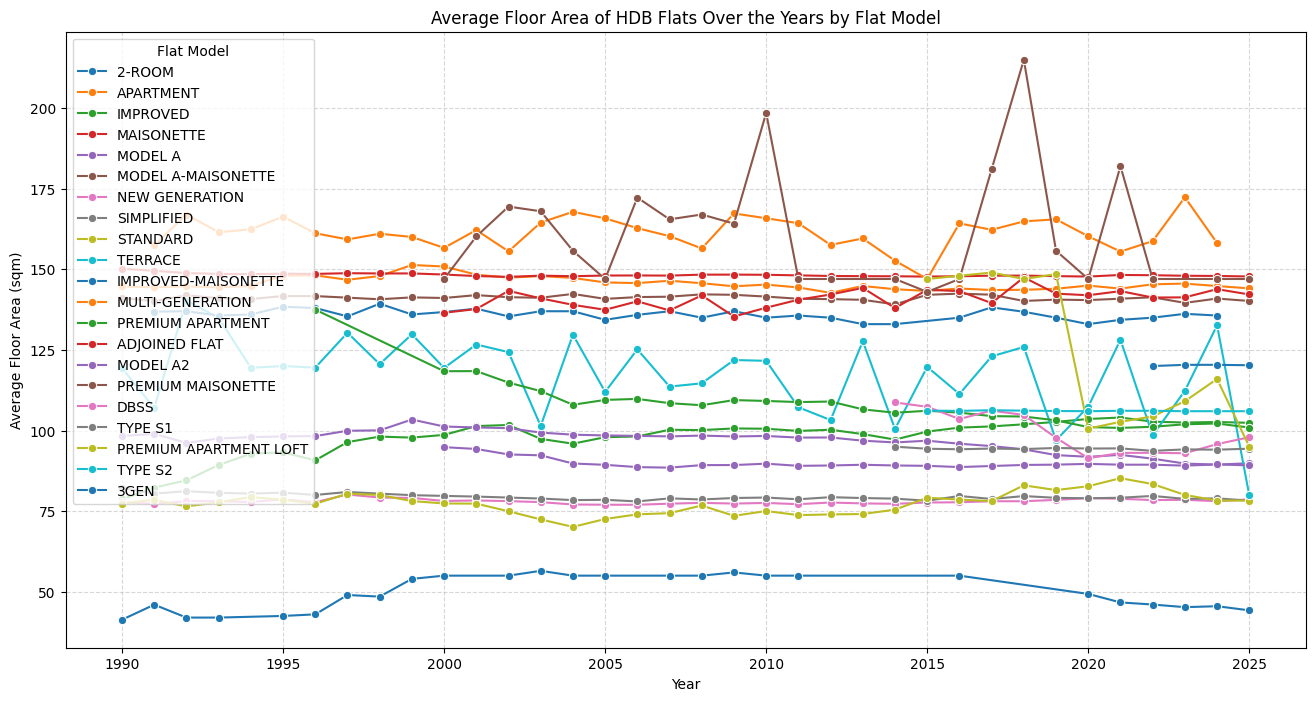

In [61]:
# Group by year and flat_type, then compute mean floor area
yearly_floor_model = df.groupby(["year", "flat_model"])["floor_area_sqm"].mean().reset_index()

# Plot the line graph
plt.figure(figsize=(16, 8))
sns.lineplot(data=yearly_floor_model, x="year", y="floor_area_sqm", hue="flat_model", marker="o", palette="tab10")

# Formatting
plt.xlabel("Year")
plt.ylabel("Average Floor Area (sqm)")
plt.title("Average Floor Area of HDB Flats Over the Years by Flat Model")
plt.legend(title="Flat Model")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [62]:
ohe = OneHotEncoder(sparse_output=False)

ohe.fit(df[['region']])
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")
df[ohe.get_feature_names_out()] = ohe.transform(df[['region']])
df = df.drop(columns=["region"])

ohe.fit(df[['flat_type']])
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")
df[ohe.get_feature_names_out()] = ohe.transform(df[['flat_type']])
df = df.drop(columns=["flat_type"])

ohe.fit(df[['flat_model']])
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")
df[ohe.get_feature_names_out()] = ohe.transform(df[['flat_model']])
df = df.drop(columns=["flat_model"])

ohe.fit(df[['town']])
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")
df[ohe.get_feature_names_out()] = ohe.transform(df[['town']])
df = df.drop(columns=["town", "storey_range"]) #dropping storey_range as unable to better use it for now
df

The categories detected by the OneHotEncoder are [array(['Central', 'East', 'North', 'North-East', 'West'], dtype=object)]
The categories detected by the OneHotEncoder are [array(['1 ROOM', '2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE',
       'MULTI-GENERATION'], dtype=object)]
The categories detected by the OneHotEncoder are [array(['2-ROOM', '3GEN', 'ADJOINED FLAT', 'APARTMENT', 'DBSS', 'IMPROVED',
       'IMPROVED-MAISONETTE', 'MAISONETTE', 'MODEL A',
       'MODEL A-MAISONETTE', 'MODEL A2', 'MULTI-GENERATION',
       'NEW GENERATION', 'PREMIUM APARTMENT', 'PREMIUM APARTMENT LOFT',
       'PREMIUM MAISONETTE', 'SIMPLIFIED', 'STANDARD', 'TERRACE',
       'TYPE S1', 'TYPE S2'], dtype=object)]
The categories detected by the OneHotEncoder are [array(['ANG MO KIO', 'BEDOK', 'BISHAN', 'BUKIT BATOK', 'BUKIT MERAH',
       'BUKIT PANJANG', 'BUKIT TIMAH', 'CENTRAL AREA', 'CHOA CHU KANG',
       'CLEMENTI', 'GEYLANG', 'HOUGANG', 'JURONG EAST', 'JURONG WEST',
       'KALLANG/WHAMPOA', '

,month,block,street_name,floor_area_sqm,lease_commence_date,resale_price,year,day,psm,region_Central,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
0,01,309,ANG MO KIO AVE 1,31.0,1977,9000.0,1990,01,290.322581,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,01,44,BENDEMEER RD,63.0,1981,31400.0,1990,01,498.412698,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,01,20,ST. GEORGE'S RD,67.0,1984,66500.0,1990,01,992.537313,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,01,14,KG ARANG RD,103.0,1984,77000.0,1990,01,747.572816,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,01,46,OWEN RD,68.0,1982,58000.0,1990,01,852.941176,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949506,03,613A,TAMPINES NTH DR 1,93.0,2020,795000.0,2025,03,8548.387097,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
949507,03,608A,TAMPINES NTH DR 1,93.0,2020,715000.0,2025,03,7688.172043,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
949508,03,609A,TAMPINES NTH DR 1,93.0,2020,790000.0,2025,03,8494.623656,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
949509,03,113,TAMPINES ST 11,115.0,1982,700000.0,2025,03,6086.956522,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [63]:
df["month"] = df["month"].astype(int)
df["day"] = df["day"].astype(int)

In [64]:
df = df.sort_values(by="year")
split_ratio = 0.02 # ~1 year for val, ~1 year for test

test_length = int(len(df) * split_ratio)
val_length = int((len(df)-test_length) * split_ratio)
train_length = len(df) - val_length - test_length

df_train = df.iloc[:train_length, :].sample(frac=1) # Shuffle datasets to improve training
df_val = df.iloc[train_length: train_length + val_length, :].sample(frac=1)
df_test = df.iloc[train_length+val_length:, :].sample(frac=1)

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

assert len(df_train) + len(df_val) + len(df_test) == len(df)

(910077, 69)
(18573, 69)
(18952, 69)


In [65]:
scaler = RobustScaler()

num_cols = ["floor_area_sqm", "resale_price", "psm"]
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])

df_val[num_cols] = scaler.transform(df_val[num_cols])
df_test[num_cols] = scaler.transform(df_test[num_cols])

df_train

,month,block,street_name,floor_area_sqm,lease_commence_date,resale_price,year,day,psm,region_Central,...,town_PASIR RIS,town_PUNGGOL,town_QUEENSTOWN,town_SEMBAWANG,town_SENGKANG,town_SERANGOON,town_TAMPINES,town_TOA PAYOH,town_WOODLANDS,town_YISHUN
176752,12,633,YISHUN ST 61,1.450,1987,1.082192,1997,12,0.316011,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
612189,6,878,YISHUN ST 81,-0.725,1988,-0.205479,2010,6,0.513654,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
653924,1,986C,JURONG WEST ST 93,0.475,2008,1.066210,2012,1,0.960783,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
293070,3,23,TOA PAYOH EAST,-0.650,1970,-0.675799,2000,3,-0.412566,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
299276,5,3,BEDOK STH AVE 1,-0.850,1976,-0.616438,2000,5,-0.134407,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592672,11,623,ANG MO KIO AVE 9,-0.025,1980,0.232877,2009,11,0.440095,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
564853,12,212,TAMPINES ST 23,-0.500,1985,-0.205479,2008,12,0.255011,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
703565,9,27,MARINE CRES,0.825,1975,2.360731,2014,9,1.896129,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887904,12,530C,PASIR RIS DR 1,-0.175,2015,1.986301,2022,12,2.998691,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
X_train = df_train.drop(columns=['resale_price', 'psm', 'block', 'street_name'])
y_train = df_train[["resale_price"]]

X_val = df_val.drop(columns=['resale_price', 'psm', 'block', 'street_name'])
y_val = df_val[["resale_price"]]

X_test = df_test.drop(columns=['resale_price', 'psm', 'block', 'street_name'])
y_test = df_test[["resale_price"]]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(910077, 65)
(910077, 1)
(18573, 65)
(18573, 1)
(18952, 65)
(18952, 1)


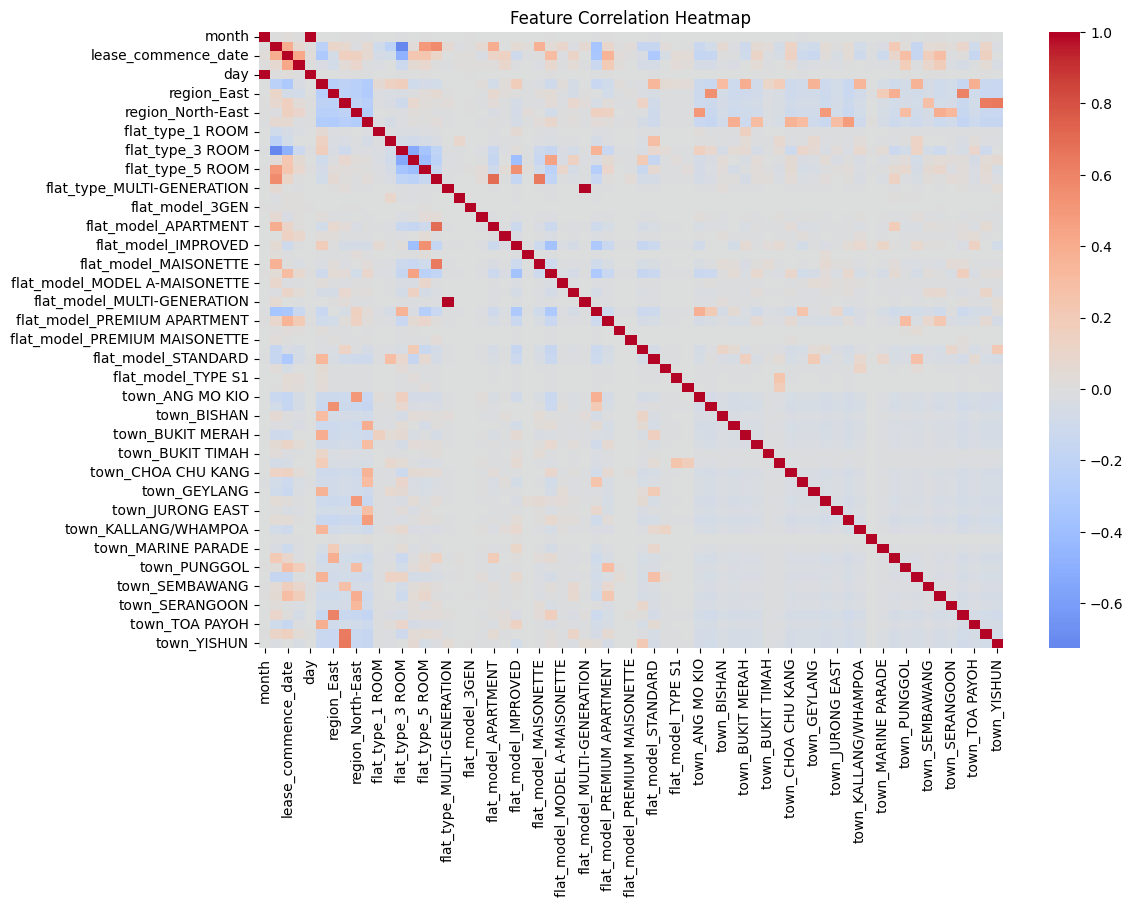

In [67]:
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

In [68]:
X_train = X_train.drop(columns=['day', 'flat_type_MULTI-GENERATION'])
X_test = X_test.drop(columns=['day', 'flat_type_MULTI-GENERATION'])
X_val = X_val.drop(columns=['day', 'flat_type_MULTI-GENERATION'])

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(910077, 63)
(910077, 1)
(18573, 63)
(18573, 1)
(18952, 63)
(18952, 1)


In [69]:
model1 = LinearRegression()

model1.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": model1.coef_.flatten()
})
print(feature_importance.sort_values(by="Coefficient", ascending=False))

                              Feature  Coefficient
35                 flat_model_TYPE S2     1.341872
34                 flat_model_TYPE S1     1.174868
29  flat_model_PREMIUM APARTMENT LOFT     0.868028
33                 flat_model_TERRACE     0.598227
52                 town_MARINE PARADE     0.454840
..                                ...          ...
32                flat_model_STANDARD    -0.423527
20                flat_model_IMPROVED    -0.428631
31              flat_model_SIMPLIFIED    -0.453257
15                  flat_model_2-ROOM    -0.473174
25                flat_model_MODEL A2    -0.483720

[63 rows x 2 columns]


In [70]:
y_pred = model1.predict(X_val)

r2 = r2_score(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"R-squared: {r2:.4f}")
print(f"RMSE: {rmse:.2f}")

R-squared: 0.5130
RMSE: 0.60


In [74]:
df.to_csv('../../data/intermediate/data_preproc.csv', index=False)

In [ ]:
# 1- RNN Architecture
model = Sequential()
model.add(layers.SimpleRNN(units=2, activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(layers.Dense(1, activation="linear"))

# 2- Compilation
model.compile(loss='mse',
              optimizer=Adam())

# 3- Fit
model.fit(X_train, y_train, epochs=1, verbose=0)

# 4- Predict
np.mean(model.predict(X_val))

/Users/hl/.pyenv/versions/3.10.6/envs/hdb_resale_chat_bot/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 802us/step


np.float32(0.11853692)

In [84]:
np.mean(y_val)

np.float64(1.4677516353905986)

In [85]:
# 1- RNN Architecture
model = Sequential()
model.add(layers.LSTM(units=2, activation='tanh', input_shape=(X_train.shape[1], 1)))
model.add(layers.Dense(1, activation="linear"))

# 2- Compilation
model.compile(loss='mse',
              optimizer=Adam())

# 3- Fit
model.fit(X_train, y_train, epochs=1, verbose=0)

# 4- Predict
np.mean(model.predict(X_val))

/Users/hl/.pyenv/versions/3.10.6/envs/hdb_resale_chat_bot/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


np.float32(0.21838693)